In [1]:
import numpy as np
import os
import h5py
from getdist import plots, MCSamples
import getdist
import dynesty 
from dynesty import plotting as dyplot
from dynesty import utils as dyfunc
import pickle

import matplotlib
from matplotlib import pylab
%config InlineBackend.figure_format = 'retina'
matplotlib.rcParams['figure.dpi'] = 80
textsize = 'x-large'
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (6, 4),
         'axes.labelsize': textsize,
         'axes.titlesize': textsize,
         'xtick.labelsize': textsize,
         'ytick.labelsize': textsize,
         'figure.facecolor': 'w'}
pylab.rcParams.update(params)
from matplotlib import pyplot as plt

%load_ext autoreload
%autoreload 2
import plotter
import utils
import emulator

In [2]:
pickle_dir = f'../products/dynesty_results'

In [3]:
cosmo_params = ['Omega_m', 'Omega_b', 'sigma_8', 'h', 'n_s', 'N_eff', 'w']
hod_params = ['M_sat', 'alpha', 'M_cut', 'sigma_logM', 'v_bc', 'v_bs', 'c_vir', 'f']
ab_params = ['f_env', 'delta_env', 'sigma_env']
hod_interest = ['M_sat', 'M_cut', 'alpha', 'f_env', 'delta_env']
all_interest = ['Omega_m', 'sigma_8', 'M_sat', 'f_env', 'delta_env']
key_params = ['Omega_m', 'sigma_8', 'M_sat', 'v_bc', 'v_bs', 'f', 'f_env']
all_params = ['Omega_m', 'Omega_b', 'sigma_8', 'h', 'n_s', 'N_eff', 'w', 'M_sat', 'alpha', 'M_cut', 'sigma_logM', 'v_bc', 'v_bs', 'c_vir', 'f', 'f_env', 'delta_env', 'sigma_env']
bi_params = ['Omega_b', 'sigma_8', 'h', 'w', 'delta_env']

In [4]:
param_labels = {'Omega_m': '\Omega_m', 
                'Omega_b': '\Omega_b', 
                'sigma_8': '\sigma_8', 
                'h': 'h', 
                'n_s': 'n_s',
                'N_eff': 'N_{eff}', 
                'w': 'w', 
                'M_sat': 'M_{sat}', 
                'alpha': r'\alpha', 
                'M_cut': 'M_{cut}', 
                'sigma_logM': '\sigma_{logM}', 
                'v_bc': 'v_{bc}', 
                'v_bs': 'v_{bs}', 
                'c_vir': 'c_{vir}', 
                'f': 'f', 
                'f_env': 'f_{env}', 
                'delta_env': '\delta_{env}', 
                'sigma_env': '\sigma_{env}'}

In [5]:
nbins = 9
rbins = np.logspace(np.log10(0.1), np.log10(50), nbins + 1) # Note the + 1 to nbins
rlog = 10 ** (0.5 * (np.log10(rbins)[1:] + np.log10(rbins)[:-1]))
rlin = np.linspace(5, 45, 9)
r_dict = {'wp': rlog, 'xi': rlog, 'upf': rlin, 'mcf': rlog}
scale_dict = {'wp': ('log', 'log'), 'xi': ('log', 'log'), 'upf': ('linear', 'log'), 'mcf': ('log', 'linear')} #x, y

In [6]:
bounds = utils.get_emulator_bounds()

In [7]:
def plot_contours_dynesty(chaintags, legend_labels=None, params_toplot=None, colors=None, 
                  legend_loc='upper center', legend_fontsize=20, 
                  vertical_markers=None, vertical_marker_color='grey'): 
    
    sample_arr = []
    for i, chaintag in enumerate(chaintags):

        chain_fn = f'../chains/chains_{chaintag}.h5'
        fw = h5py.File(chain_fn, 'r')
        param_names = fw.attrs['param_names']
        if vertical_markers is None:
            vertical_markers = fw.attrs['true_values']
        fw.close()
        
        pickle_fn = f'{pickle_dir}/results_{chaintag}.pkl'
        with open(pickle_fn, 'rb') as pf:
            res = pickle.load(pf)
            samples = res['samples']
            lnweight = np.array(res['logwt'])
            lnevidence = np.array(res['logz'])

        if params_toplot is not None:    
            idxs = []
            for pm in params_toplot:
                idxs.append(np.where(param_names == pm))
            idxs = np.array(idxs).flatten()
            samples = samples[:,idxs]
            param_names = params_toplot
            vertical_markers = vertical_markers[idxs]
        
        labels = [param_labels[pn] for pn in param_names]
        ranges = [bounds[pn] for pn in param_names]

        #[-1] bc just care about final evidence value
        weights = np.exp(lnweight - lnevidence[-1]) 
        weights = weights.flatten()

        samps = MCSamples(names=param_names, labels=labels)
        samps.setSamples(samples, weights=weights)
        sample_arr.append(samps)

    marker_args = {'color': vertical_marker_color}
        
    g = plots.get_subplot_plotter()
    g.settings.alpha_filled_add=0.4
    g.settings.figure_legend_frame = False
    g.settings.legend_fontsize = legend_fontsize
    g.settings.axis_marker_lw = 1.0
    g.settings.axis_marker_color = 'dimgrey'
    g.triangle_plot(sample_arr, filled=True, contour_colors=colors, names=param_names,
                   legend_labels=legend_labels, markers=vertical_markers, title_limit=1, legend_loc=legend_loc,
                    marker_args=marker_args, axis_marker_color='red')
    return g

## plot fits

dict_keys(['nlive', 'niter', 'ncall', 'eff', 'samples', 'samples_id', 'samples_it', 'samples_u', 'logwt', 'logl', 'logvol', 'logz', 'logzerr', 'information', 'bound', 'bound_iter', 'samples_bound', 'scale'])


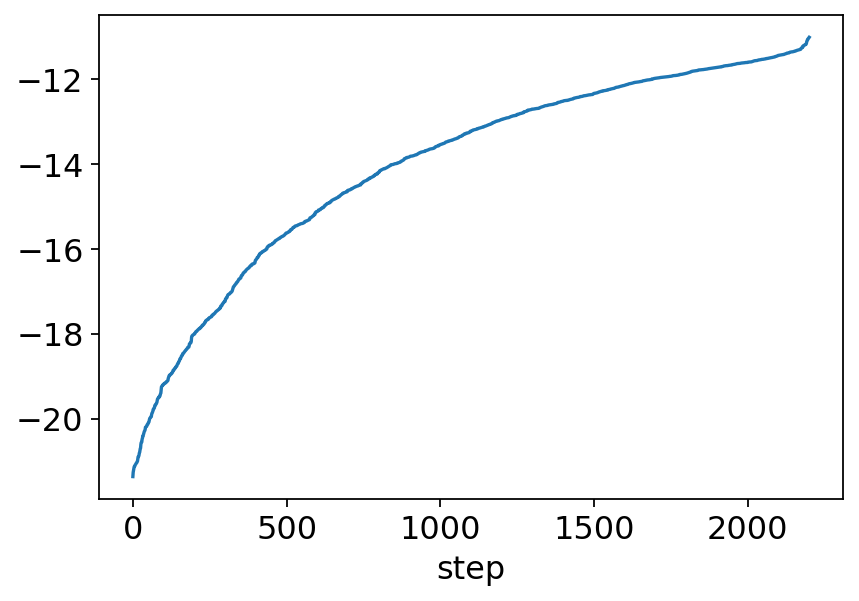

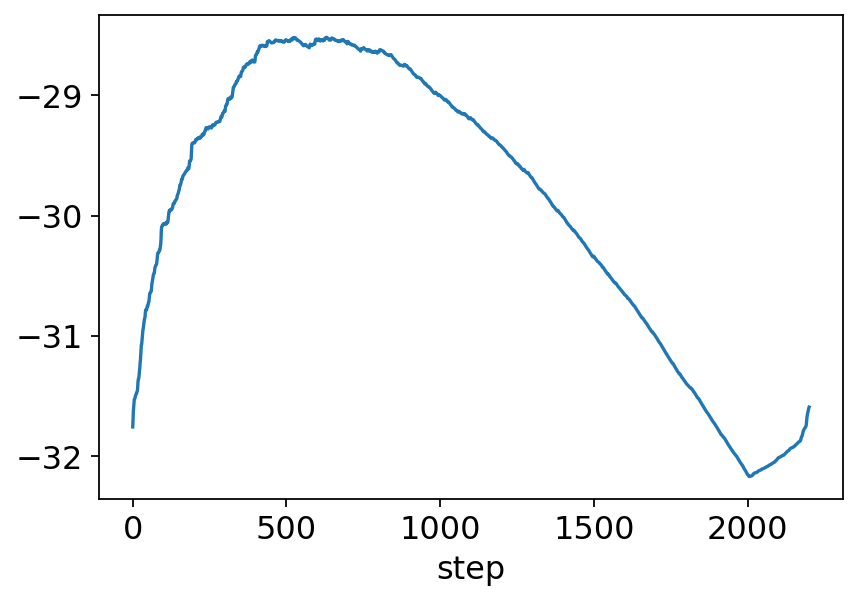

In [157]:
chaintag = 'wp_xi_upf_mcf_c3h3_allcosmo_dynesty_dlogz1e-2_nongen_hpriorg'
pickle_fn = f'{pickle_dir}/results_{chaintag}.pkl'
with open(pickle_fn, 'rb') as pf:
    res = pickle.load(pf)
    samples = res['samples']
    logl = res['logl']
    print(res.keys())
    
    #plt.plot(-logl)
    #plt.yscale('log')
    plt.figure()
    plt.plot(logl[1000:])
    plt.xlabel("step")
    plt.ylabel("")
    
    plt.figure()
    plt.plot(res['logwt'][1000:])
    plt.xlabel("step")
    plt.ylabel("")

In [53]:
def build_emus(f):
    
    #chain_fn = f'../chains/chains_{chaintag}.h5'
    #f = h5py.File(chain_fn, 'r')
    
    ### data params
    cosmo = f.attrs['cosmo']
    hod = f.attrs['hod']
    
    ### emu params
    statistics = f.attrs['statistic']
    traintags = f.attrs['traintag']
    testtags = f.attrs['testtag']
    errtags = f.attrs['errtag']
    tags = f.attrs['tag']
    kernel_names = f.attrs['kernel_name']
    logs = f.attrs['log']
    means = f.attrs['mean']
    nhods = f.attrs['nhod']

    ### chain params
    param_names = f.attrs['param_names']
    
    # Set file and directory names
    nstats = len(statistics)
    training_dirs = [None]*nstats
    testing_dirs = [None]*nstats
    hyperparams = [None]*nstats
    acctags = [None]*nstats
    ys = []
    cov_dir = '../../clust/covariances/'
    for i, statistic in enumerate(statistics):
        gptag = traintags[i] + errtags[i] + tags[i]
        acctags[i] = gptag + testtags[i]
        res_dir = '../../clust/results_{}/'.format(statistic)
        print(cov_dir+"error_aemulus_{}{}.dat".format(statistic, errtags[i]))
        gperr = np.loadtxt(cov_dir+"error_aemulus_{}{}.dat".format(statistic, errtags[i]))
        print(gperr)
        training_dirs[i] = '{}training_{}{}/'.format(res_dir, statistic, traintags[i])
        testing_dirs[i] = '{}testing_{}{}/'.format(res_dir, statistic, testtags[i])
        hyperparams[i] = "../training_results/{}_training_results{}.dat".format(statistic, gptag)
    
    # number of parameters, out of 11 hod + 7 cosmo
    num_params = len(param_names)
    cosmo_names = ['Omega_m', 'Omega_b', 'sigma_8', 'h', 'n_s', 'N_eff', 'w']
    cosmos_truth = np.loadtxt('../tables/cosmology_camb_test_box_full.dat')

    hod_names = ['M_sat', 'alpha', 'M_cut', 'sigma_logM', 'v_bc', 'v_bs', 'c_vir', 'f', 'f_env', 'delta_env', 'sigma_env']
    hods_truth = np.loadtxt('../tables/HOD_test_np11_n1000_new_f_env.dat')
    hods_truth[:, 0] = np.log10(hods_truth[:, 0])
    hods_truth[:, 2] = np.log10(hods_truth[:, 2])

    fixed_params = {}
    cosmo_truth = cosmos_truth[cosmo]
    hod_truth = hods_truth[hod]
    for (cn, ct) in zip(cosmo_names, cosmo_truth):
        fixed_params[cn] = ct
    for (hn, ht) in zip(hod_names, hod_truth):
        fixed_params[hn] = ht

    # remove params that we want to vary from fixed param dict and add true values
    truths = f.attrs['true_values']
    for pn in param_names:
        fixed_params.pop(pn)
        
    print("Building emulators")
    emus = [None]*nstats
    for i, statistic in enumerate(statistics):
        print(f"Rebuilding emulator for {statistic}")
        print(gperr)
        emu = emulator.Emulator(statistic, training_dirs[i], testing_dir=testing_dirs[i], fixed_params=fixed_params, 
                                gperr=gperr, hyperparams=hyperparams[i], log=logs[i], 
                                mean=means[i], nhod=nhods[i], kernel_name=kernel_names[i])
        emu.build()
        emus[i] = emu
        
        
    #return emus, statistics, param_names, fixed_params, truths, cosmo, hod
    return emus, fixed_params

In [9]:
def get_maxweight_params(res):
    samples = res['samples']
    weights = res['logwt']
    argmax_weight = np.argmax(weights)
    maxweight_params = samples[argmax_weight]
    return maxweight_params

In [10]:
def get_minlogl_params(res, index=-1):
    samples = res['samples']
    minlogl_params = samples[index]
    return minlogl_params

In [11]:
def get_mean_params(res):
    samples, weights = res.samples, np.exp(res.logwt - res.logz[-1])
    mean, cov = dyfunc.mean_and_cov(samples, weights)
    return mean

In [12]:
def get_emu_predictions(emu, params_topredict, param_names, fixed_params):
    param_dict_pred = dict(zip(param_names, params_topredict))
    param_dict_pred.update(fixed_params)
    emu_preds = emu.predict(param_dict_pred)
    return emu_preds

In [13]:
def load_res(chaintag):
    pickle_fn = f'{pickle_dir}/results_{chaintag}.pkl'
    with open(pickle_fn, 'rb') as pf:
        res = pickle.load(pf)
    return res

In [15]:
def get_true_params(chaintag):
    chain_fn = f'../chains/chains_{chaintag}.h5'
    f = h5py.File(chain_fn, 'r')
    truths = f.attrs['true_values']
    return truths

In [31]:
def get_fits(chaintag, param_arr):
    
    chain_fn = f'../chains/chains_{chaintag}.h5'
    f = h5py.File(chain_fn, 'r')
    
    param_names = f.attrs['param_names']
    statistics = f.attrs['statistic']
    cosmo = f.attrs['cosmo']
    hod = f.attrs['hod']
    
    emus, fixed_params = build_emus(f)
    
    vals_arr_all = []
    vals_true_all = []

    for i, statistic in enumerate(statistics):
        vals_arr = []
        for params in param_arr:
            vals_arr.append(get_emu_predictions(emus[i], params, param_names, fixed_params))
        
        vals_arr_all.append(vals_arr)
        vals_true_all.append(emus[i].testing_data[(cosmo, hod)])

        return statistics, np.array(vals_arr_all), np.array(vals_true_all)

In [49]:
def plot_fits(statistics, vals_arr_all, vals_true, fit_labels, fit_colors, title=''):
    lss = ['-', '--', ':', '-.']
    vals_arr_all = np.array(vals_arr_all)
    vals_true = np.array(vals_true)
    
    for i, statistic in enumerate(statistics):
        fig, axarr = plt.subplots(2, 1, figsize=(7,7), sharex=True)
        plt.subplots_adjust(hspace=0, wspace=0)
        ax0, ax1 = axarr
        
        ax0.plot(r_dict[statistic], vals_true[i], label='Truth', marker='o', ls='None', color='black')
        
        for j in range(vals_arr_all.shape[1]):
            ax0.plot(r_dict[statistic], vals_arr_all[i][j], label=fit_labels[j], ls=lss[j], color=fit_colors[j])
            frac = (vals_arr_all[i][j] - vals_true[i])/vals_true[i]
            ax1.plot(r_dict[statistic], frac, label=fit_labels[j], ls=lss[j], color=fit_colors[j])
            
        ax0.set_xscale(scale_dict[statistic][0])
        ax0.set_yscale(scale_dict[statistic][1])
        ax0.set_ylabel(statistic)
        ax0.legend(fontsize=10, loc='best')
        
        ax1.axhline(0, color='darkgrey')
        ax1.set_xscale(scale_dict[statistic][0])
        ax1.set_xlabel(r"$r$")
        ax1.set_ylabel("fractional error")
        
        #ax0.title(title)

In [51]:
chaintag = 'wp_c3h3_allcosmo_dynesty_dlogz1e-2_nongen_hpriorg'
res = load_res(chaintag)
minlogl_params1 = get_minlogl_params(res, index=-1)
minlogl_params19 = get_minlogl_params(res, index=-19)
mean_params = get_mean_params(res)
true_params = get_true_params(chaintag)
param_arr = [true_params, mean_params, minlogl_params1, minlogl_params19]
statistics, vals_arr_all, vals_true_all = get_fits(chaintag, param_arr)

Building emulators
Rebuilding emulator for wp


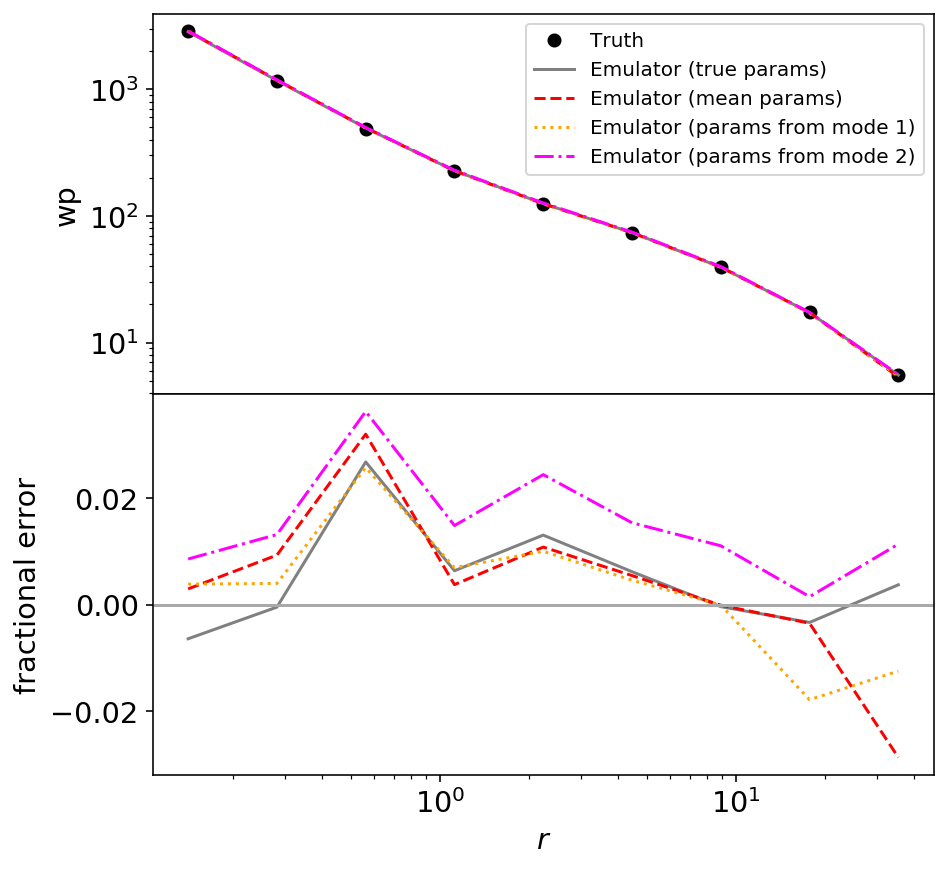

In [52]:
fit_labels = ['Emulator (true params)', 'Emulator (mean params)', 
              'Emulator (params from mode 1)', 'Emulator (params from mode 2)']
fit_colors = ['grey', 'red', 'orange', 'magenta']
plot_fits(statistics, vals_arr_all, vals_true_all, fit_labels, fit_colors, title=chaintag)

AttributeError: 'AxesSubplot' object has no attribute 'add_x_marker'

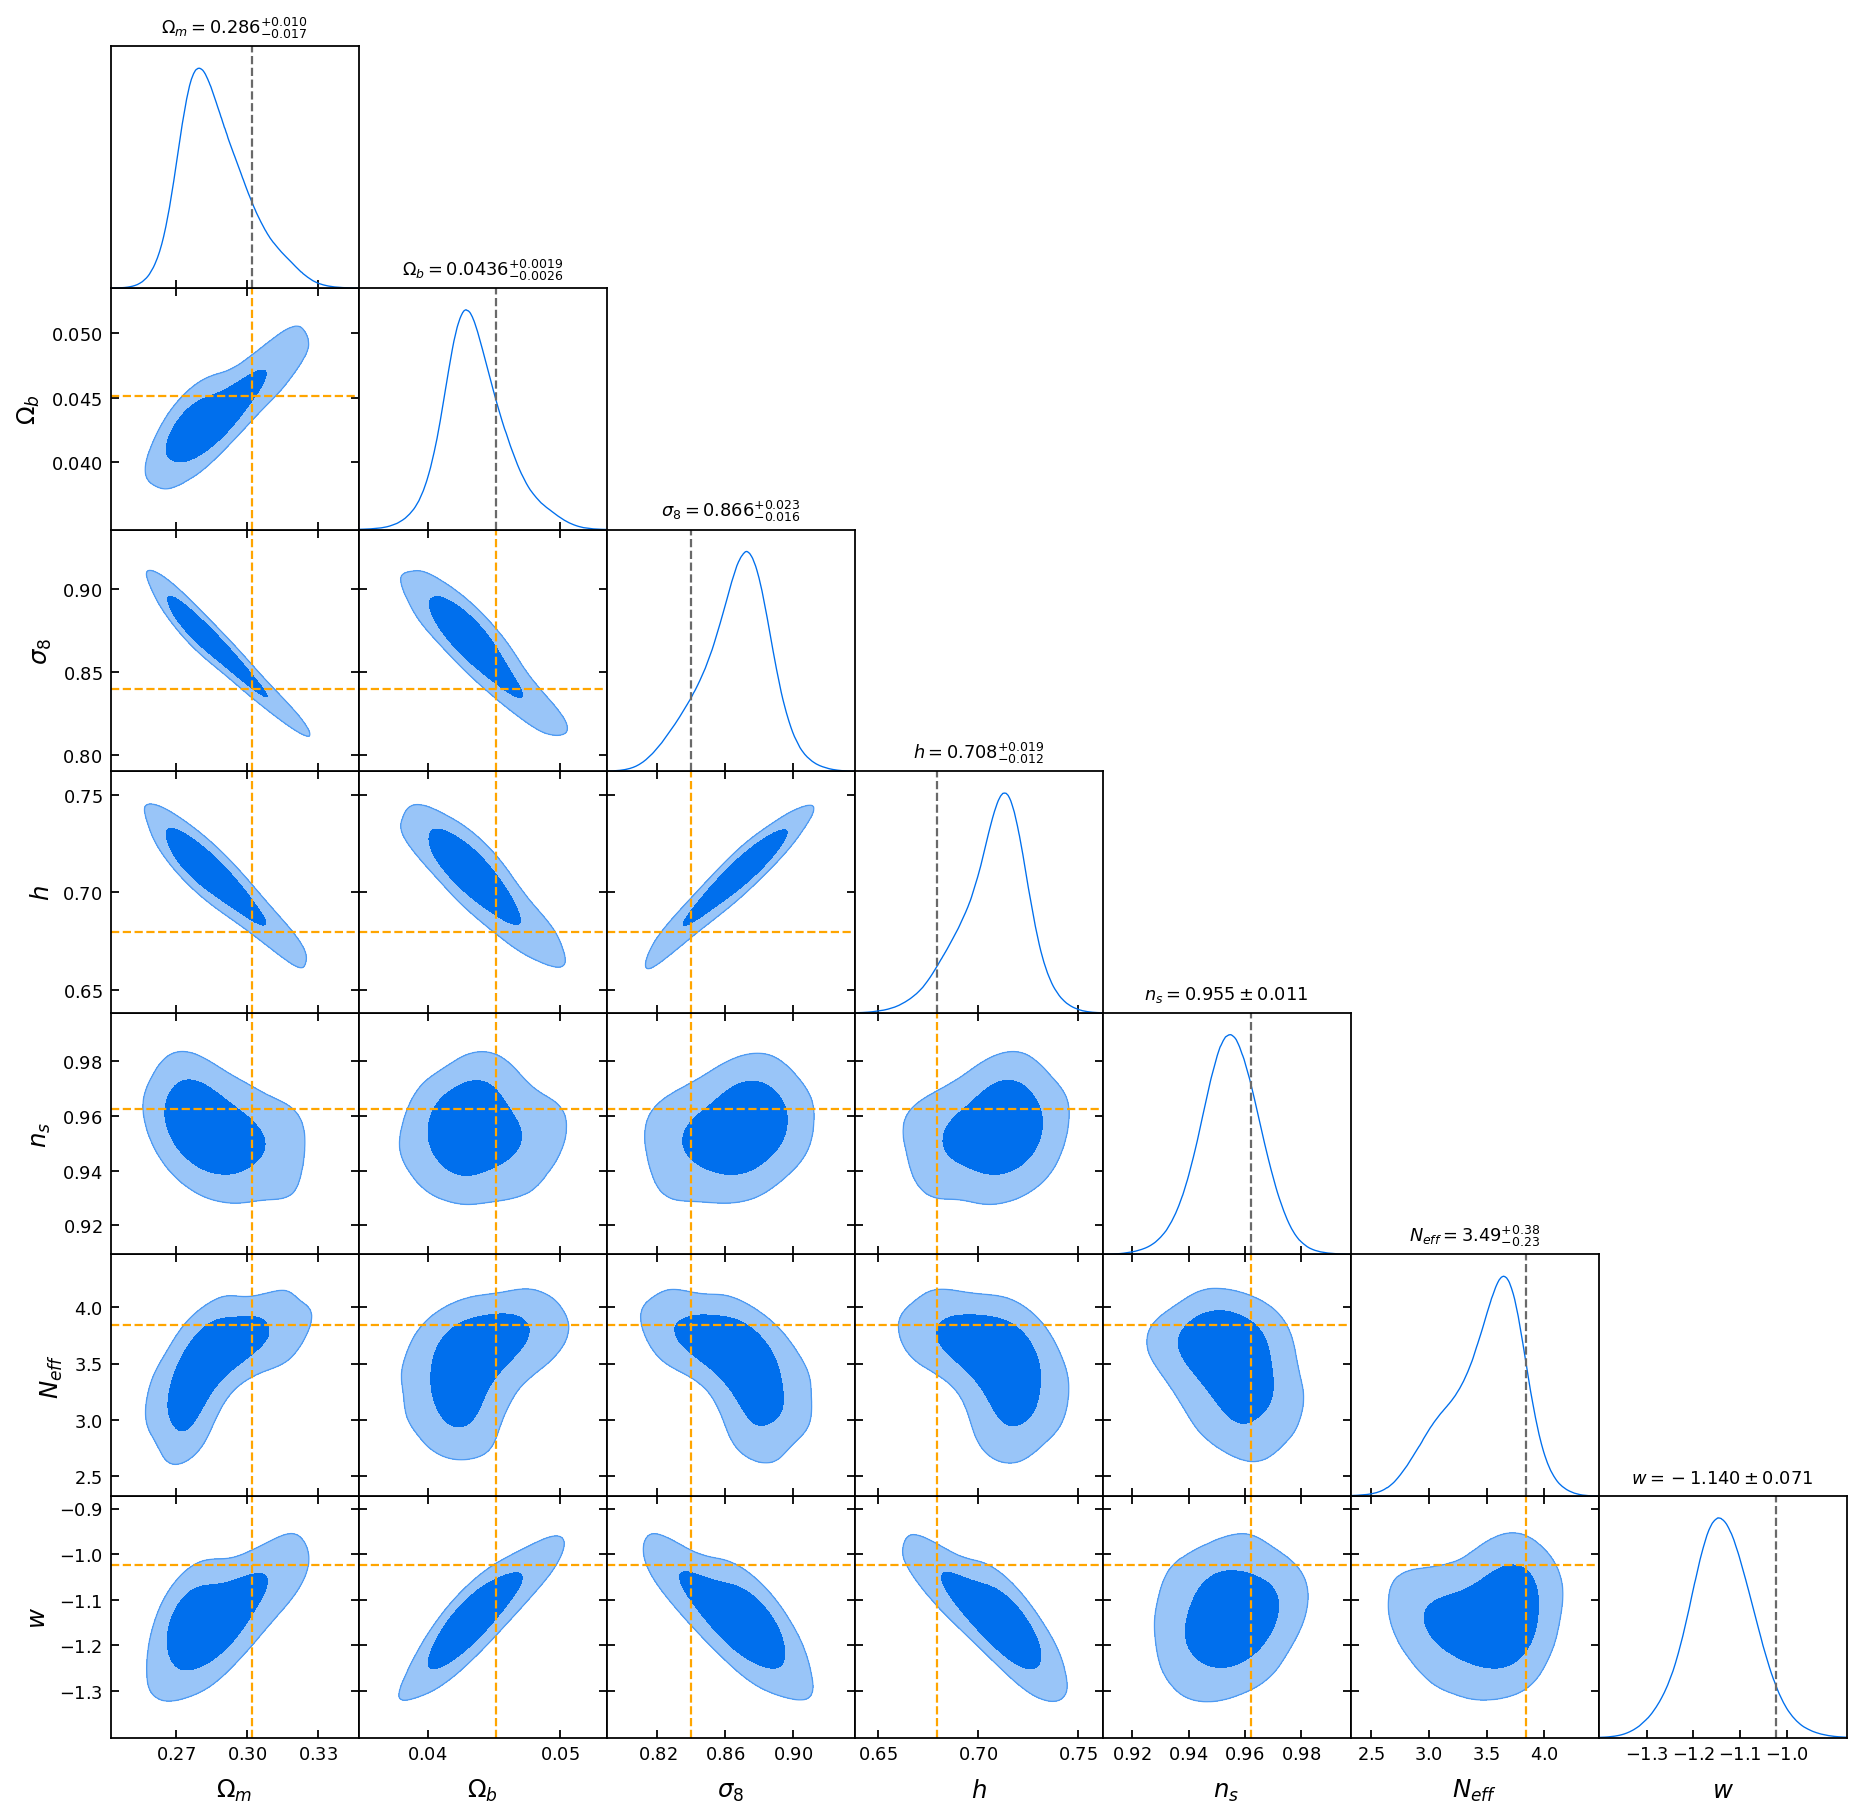

In [163]:
chaintag = 'wp_c3h3_allcosmo_dynesty_dlogz1e-2_nongen_hpriorg'
res = load_res(chaintag)
minlogl_params1 = get_minlogl_params(res, index=-1)
g = plot_contours_dynesty([chaintag], params_toplot=cosmo_params, 
                      vertical_markers=minlogl_params1, vertical_marker_color='orange')

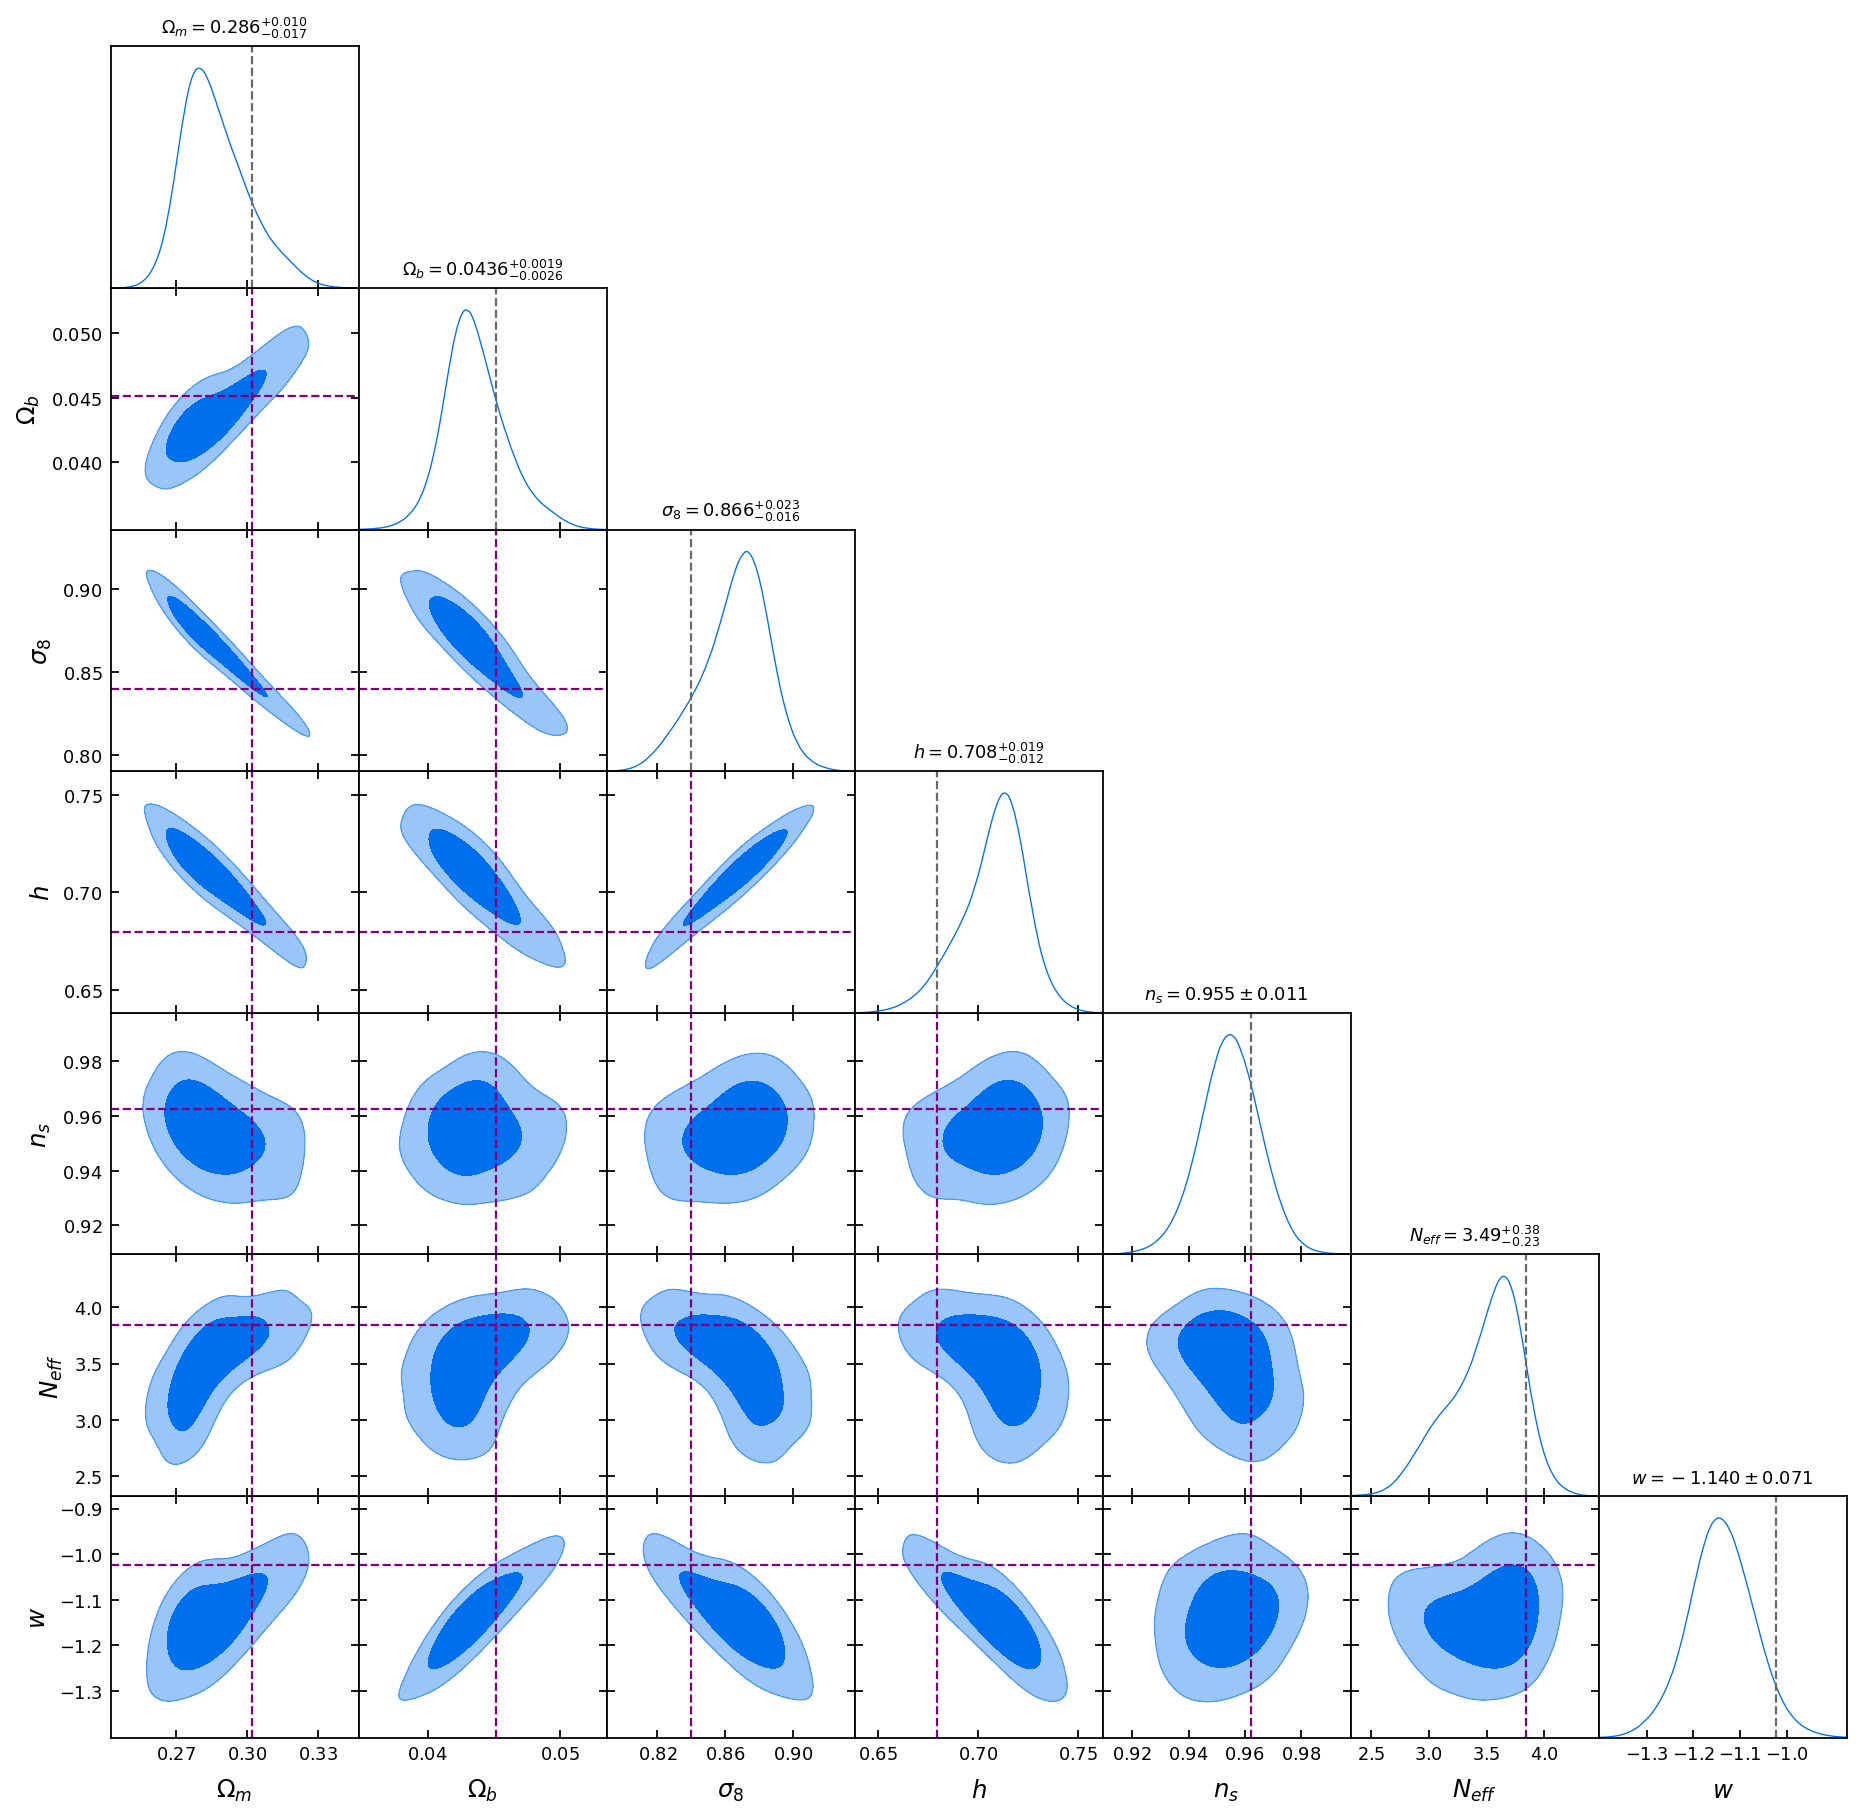

In [167]:
chaintag = 'wp_c3h3_allcosmo_dynesty_dlogz1e-2_nongen_hpriorg'
res = load_res(chaintag)
minlogl_params2 = get_minlogl_params(res, index=-2)
g = plot_contours_dynesty([chaintag], params_toplot=cosmo_params, 
                      vertical_markers=minlogl_params1, vertical_marker_color='purple')

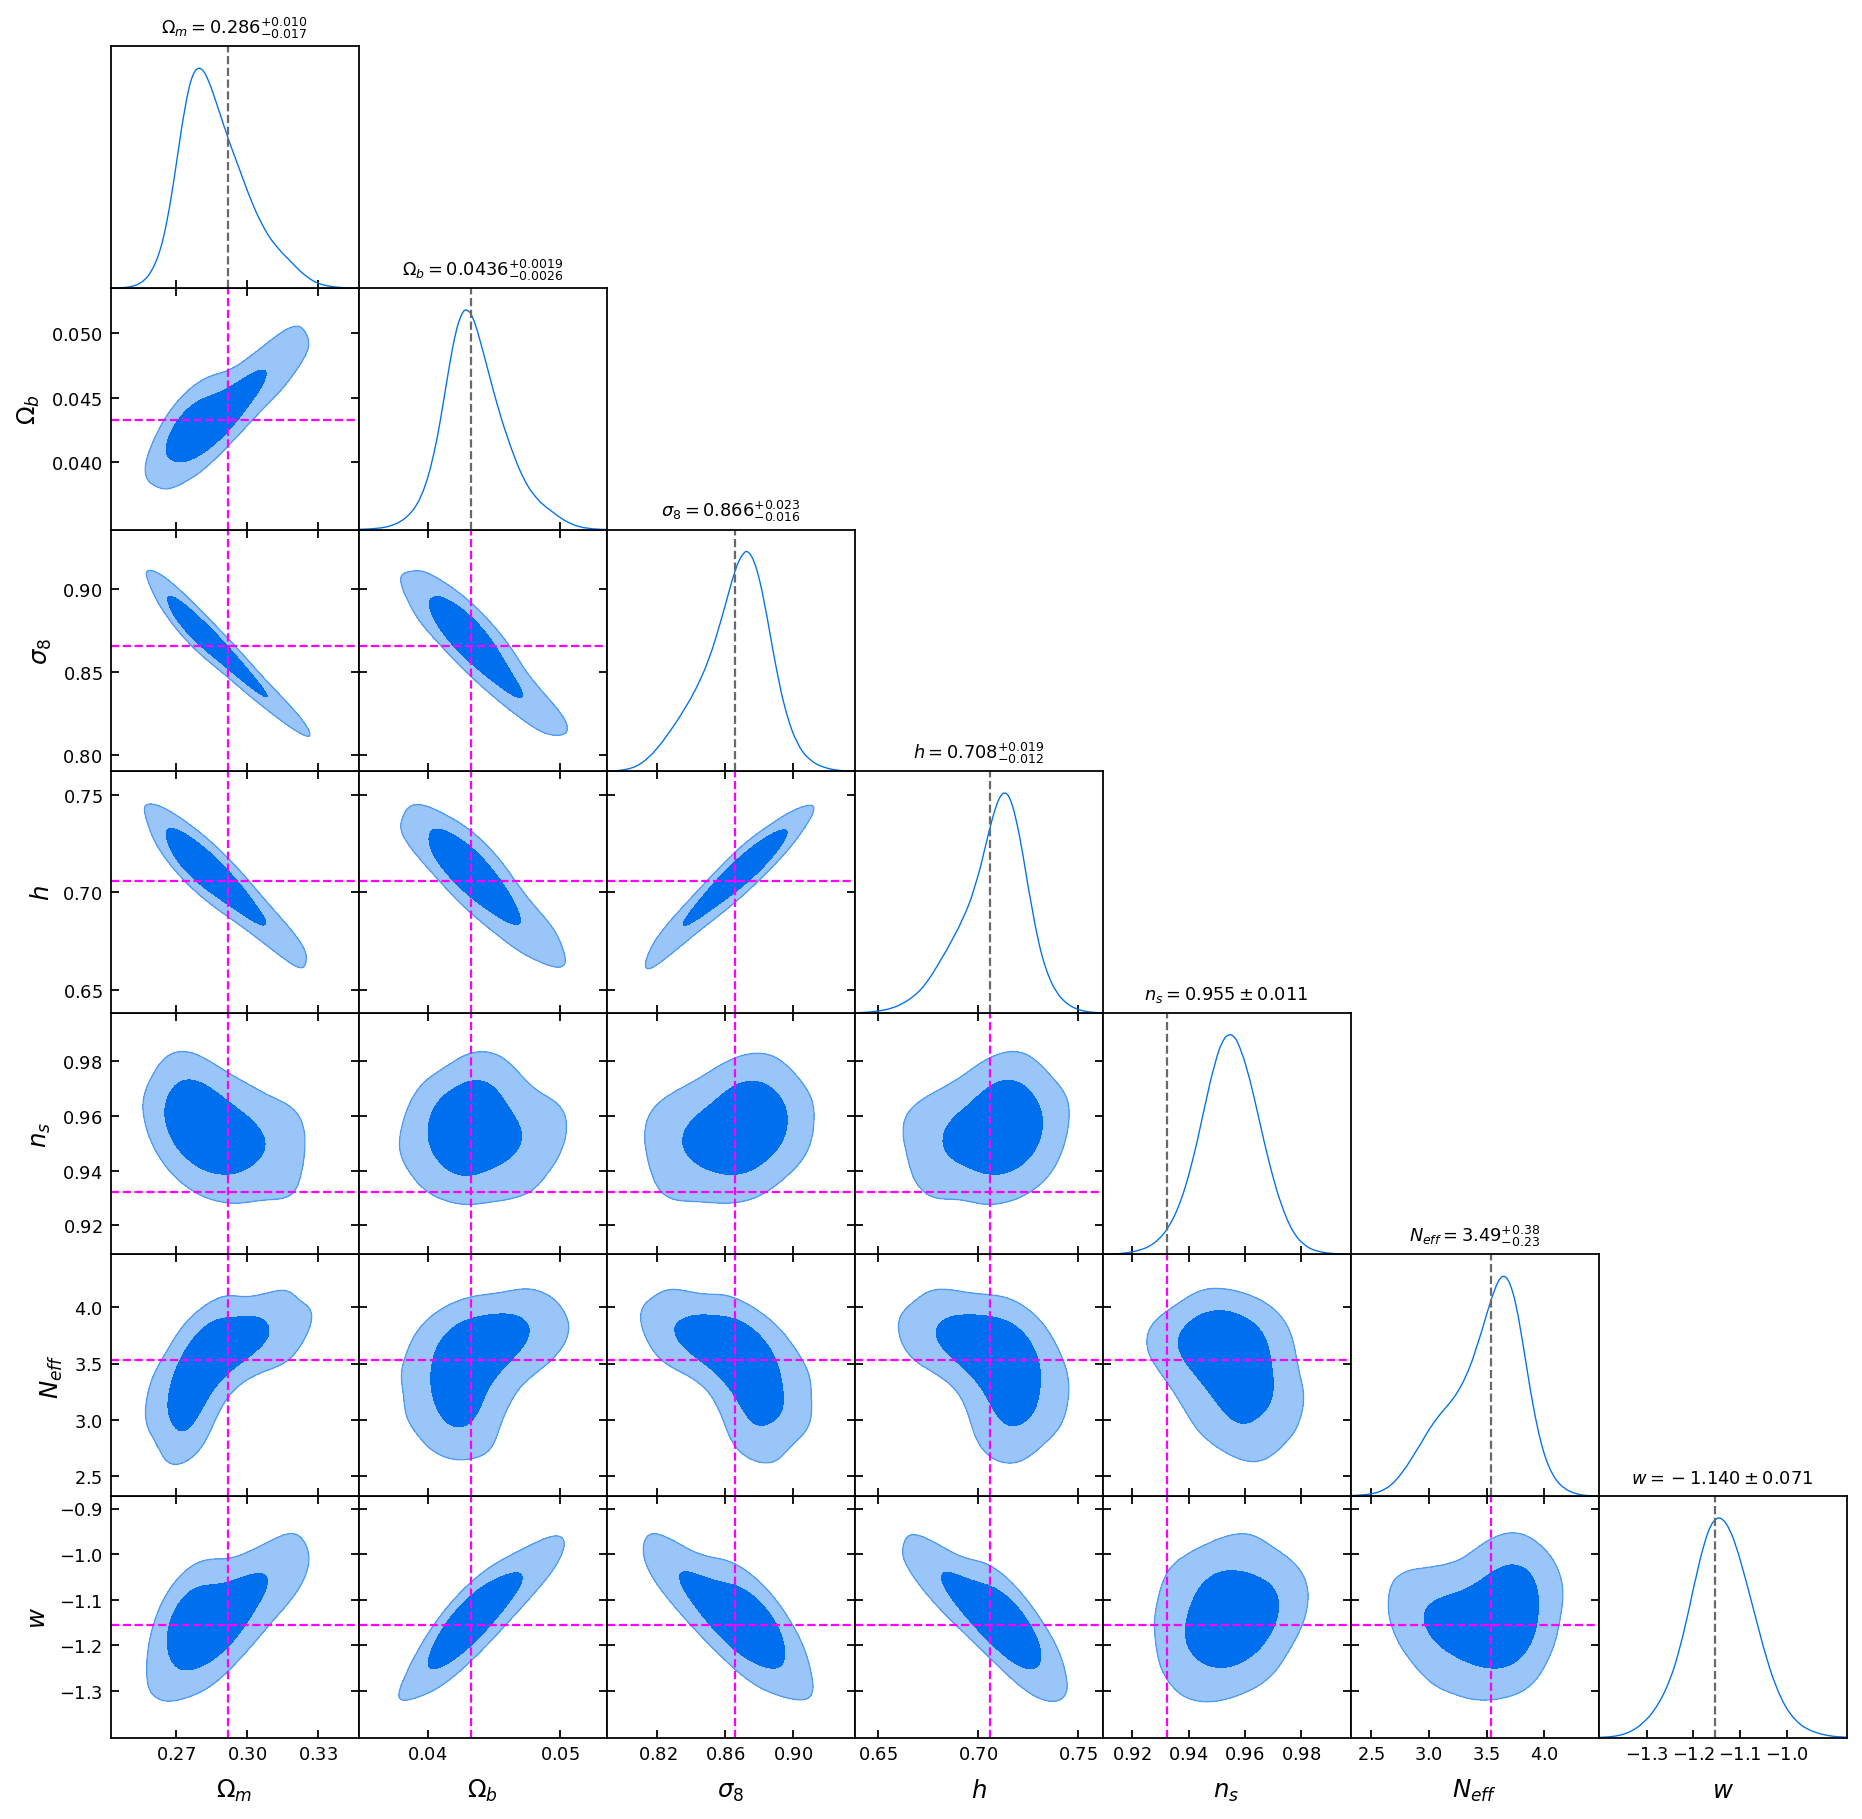

In [165]:
chaintag = 'wp_c3h3_allcosmo_dynesty_dlogz1e-2_nongen_hpriorg'
res = load_res(chaintag)
maxweight_params = get_maxweight_params(res)
plot_contours_dynesty([chaintag], params_toplot=cosmo_params, 
                      vertical_markers=maxweight_params, vertical_marker_color='magenta')

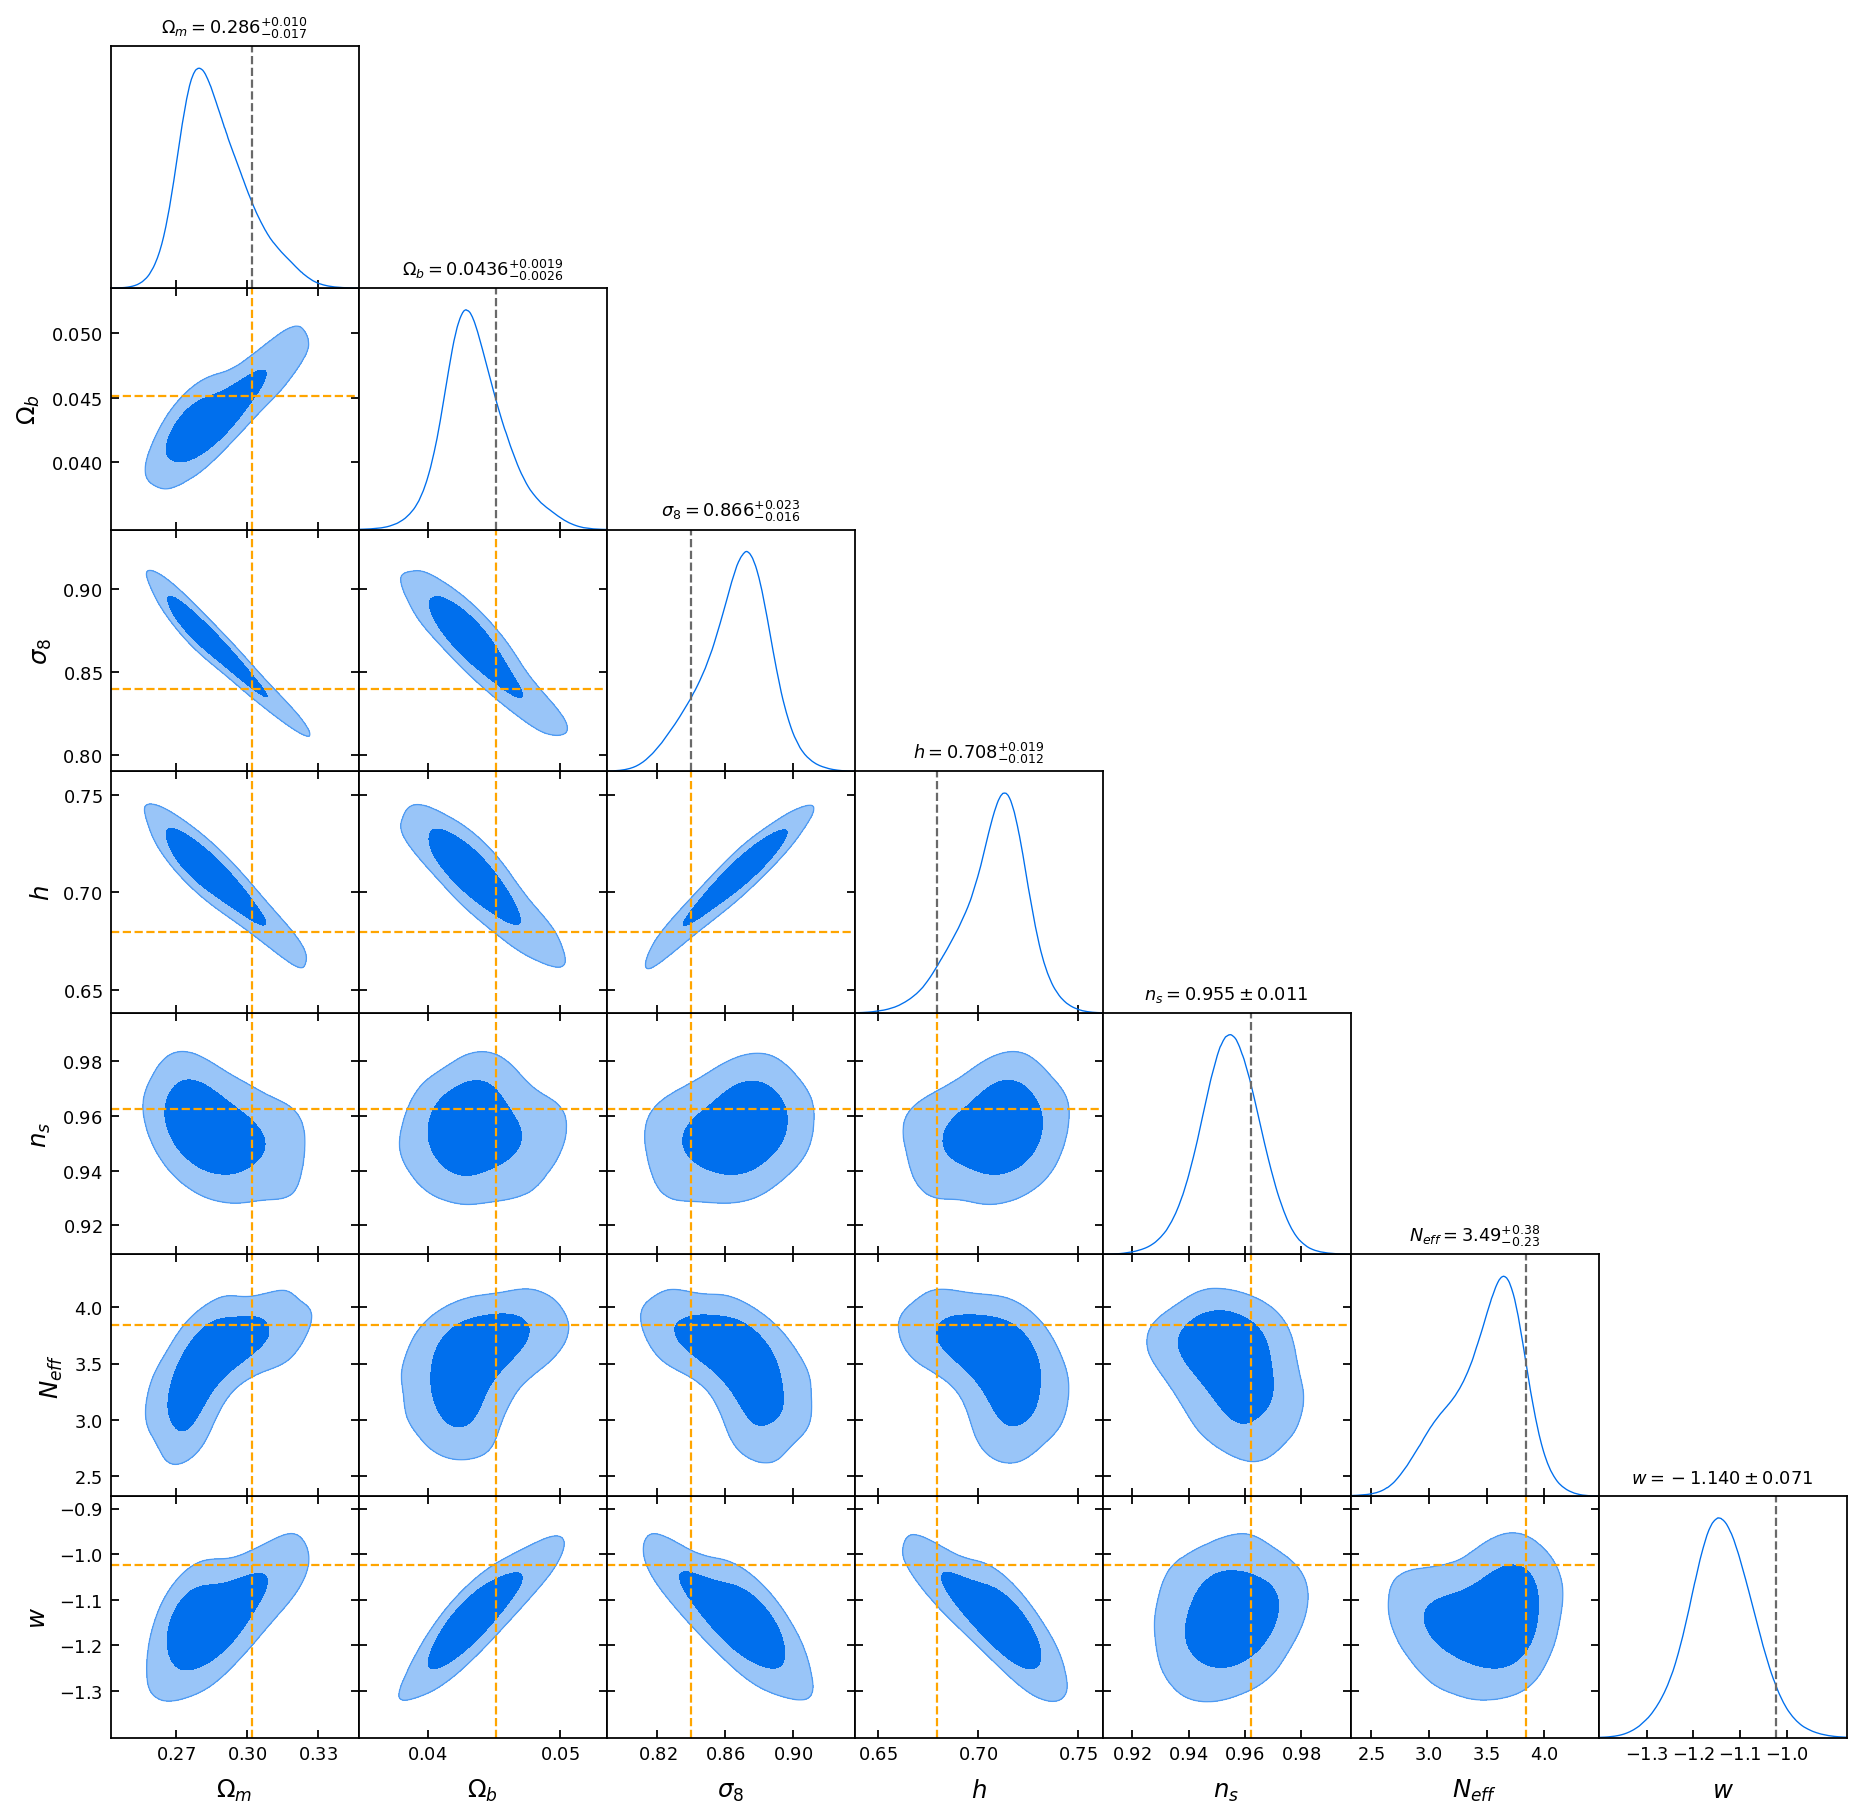

In [151]:
chaintag = 'wp_c3h3_allcosmo_dynesty_dlogz1e-2_nongen_hpriorg'
res = load_res(chaintag)
minlogl_params = get_minlogl_params(res, index=-1)
#mean_params = get_mean_posterior(res)
plot_contours_dynesty([chaintag], params_toplot=cosmo_params, 
                      vertical_markers=minlogl_params, vertical_marker_color='orange')

Building emulators
george version: 0.3.1
Loading training data
Nparams: 18
Loading testing data
Nparams: 18
Rebuilding emulators
Emulator for wp built


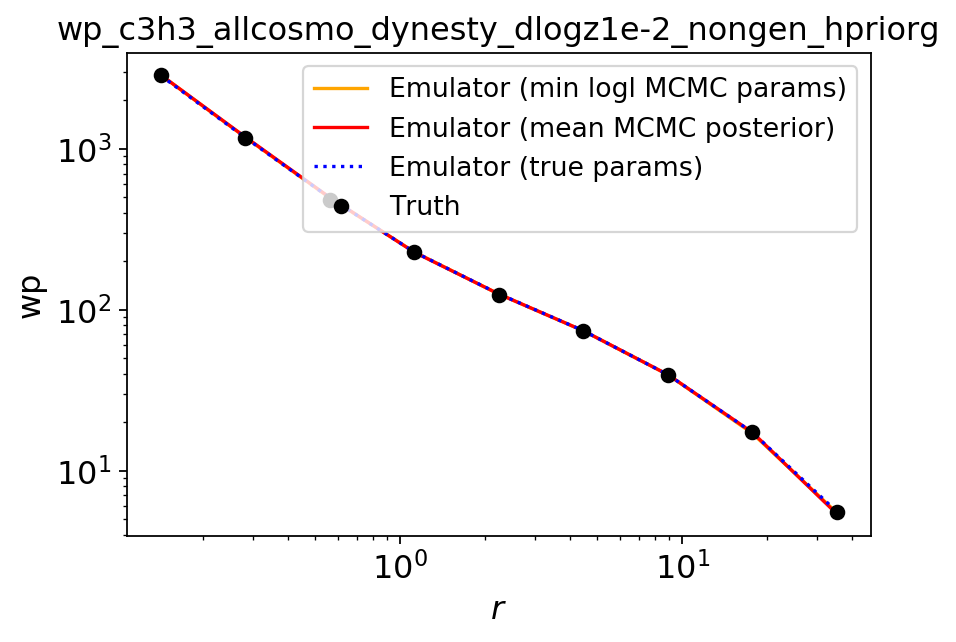

In [149]:
chaintag = 'wp_c3h3_allcosmo_dynesty_dlogz1e-2_nongen_hpriorg'
fits = get_fits(chaintag)
plot_fits(*fits, title=chaintag)

Building emulators
george version: 0.3.1
Loading training data
Nparams: 18
Loading testing data
Nparams: 18
Rebuilding emulators
Emulator for wp built


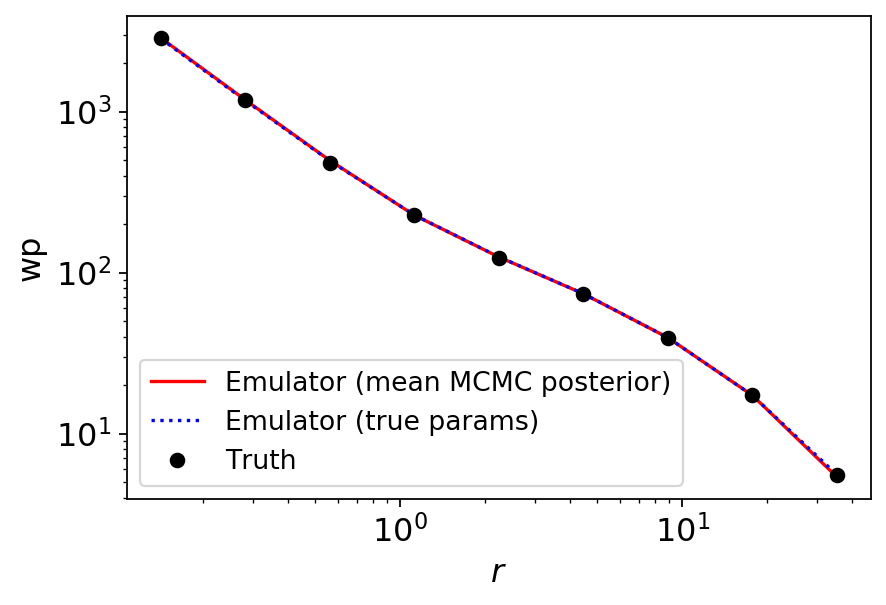

In [84]:
chaintag = 'wp_c3h3_allcosmo_dynesty_dlogz1e-2_nongen_hpriorg'
statistics, vals_pred_best, vals_pred_true, vals_actual = get_fits(chaintag)
plot_fits(statistics, vals_pred_best, vals_pred_true, vals_actual, title=chaintag)

Building emulators
george version: 0.3.1
Loading training data
Nparams: 18
Loading testing data
Nparams: 18
Rebuilding emulators
Emulator for wp built


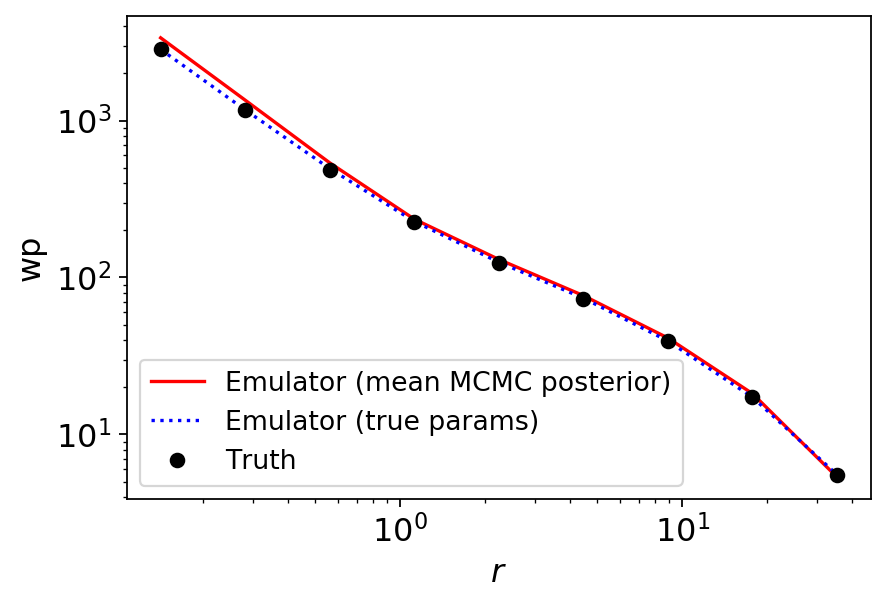

In [85]:
chaintag = 'wp_c3h3_all_dynesty_dlogz1e-2_nongen_hpriorg'
statistics, vals_pred_best, vals_pred_true, vals_actual = get_fits(chaintag)
plot_fits(statistics, vals_pred_best, vals_pred_true, vals_actual, title=chaintag)

Building emulators
george version: 0.3.1
Loading training data
Nparams: 18
Loading testing data
Nparams: 18
Rebuilding emulators
Emulator for wp built
george version: 0.3.1
Loading training data
Nparams: 18
Loading testing data
Nparams: 18
Rebuilding emulators
Emulator for xi built
george version: 0.3.1
Loading training data
Nparams: 18
Loading testing data
Nparams: 18
Rebuilding emulators
Emulator for upf built
george version: 0.3.1
Loading training data
Nparams: 18
Loading testing data
Nparams: 18
Rebuilding emulators
Emulator for mcf built


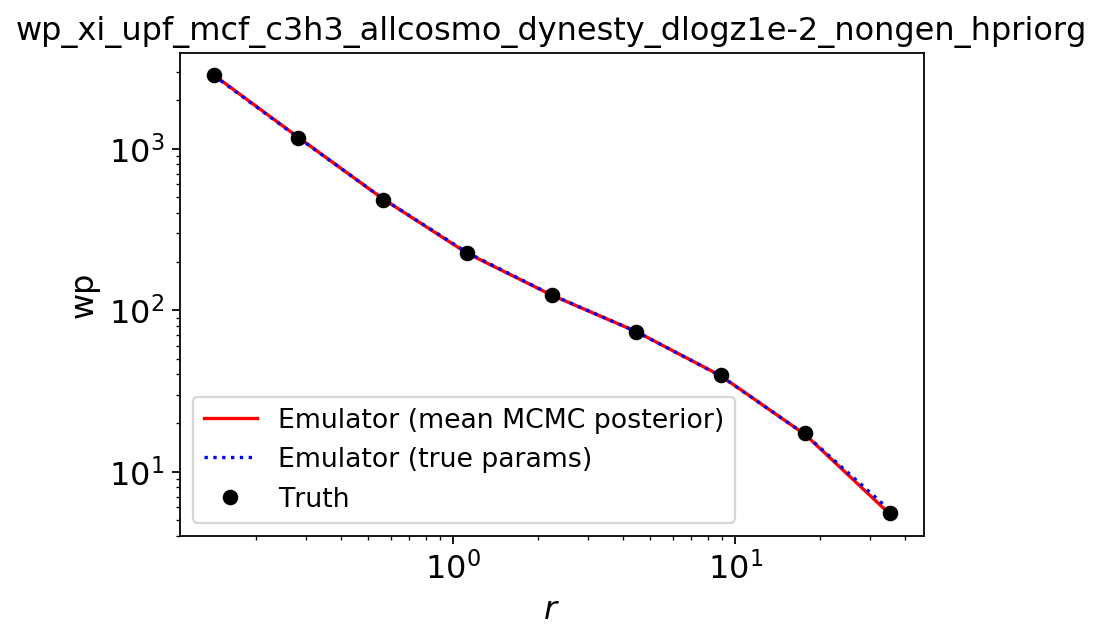

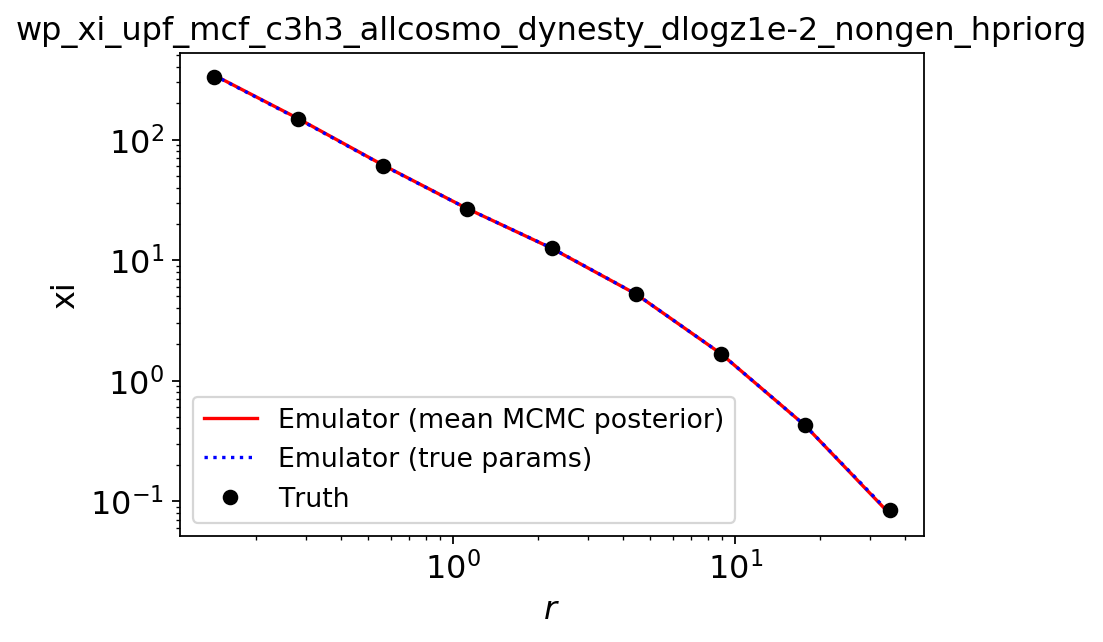

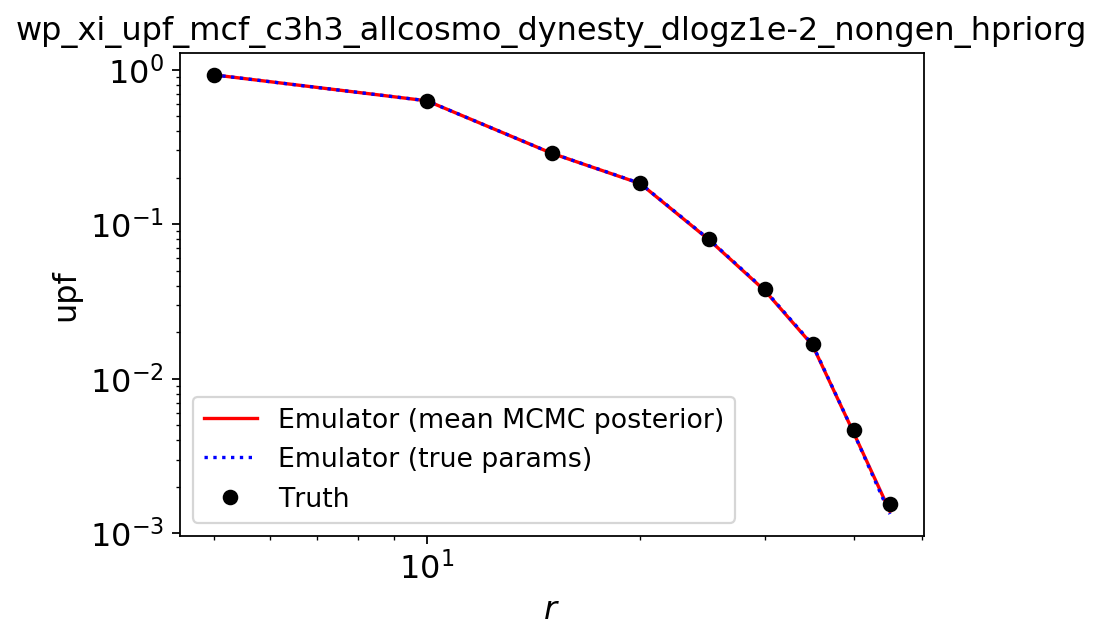

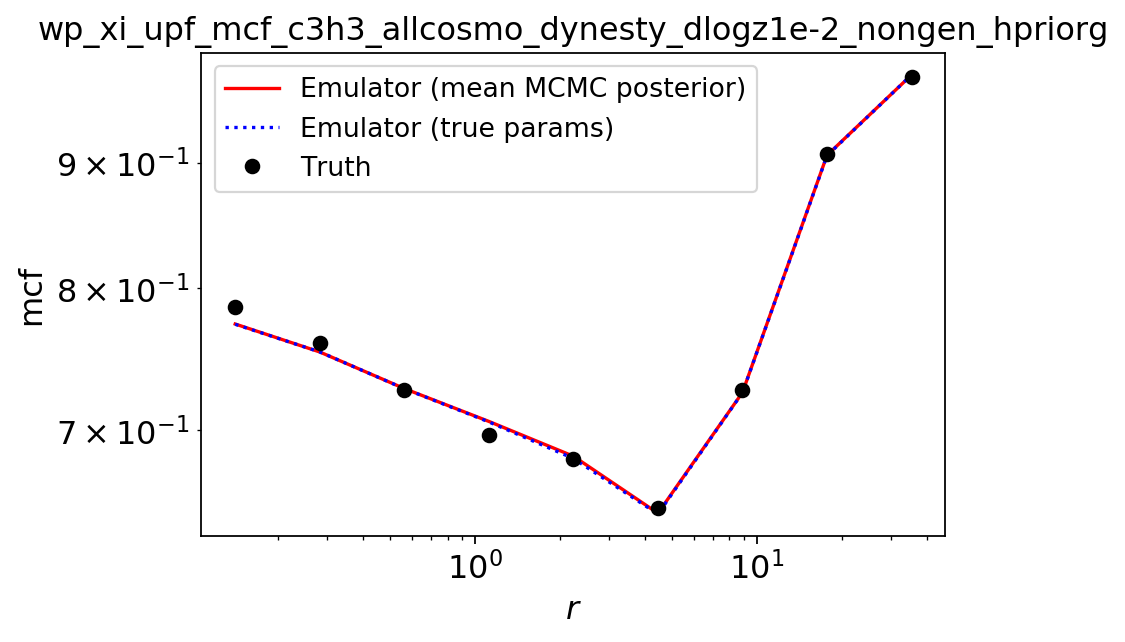

In [91]:
chaintag = 'wp_xi_upf_mcf_c3h3_allcosmo_dynesty_dlogz1e-2_nongen_hpriorg'
statistics, vals_pred_best, vals_pred_true, vals_actual = get_fits(chaintag)
plot_fits(statistics, vals_pred_best, vals_pred_true, vals_actual, title=chaintag)

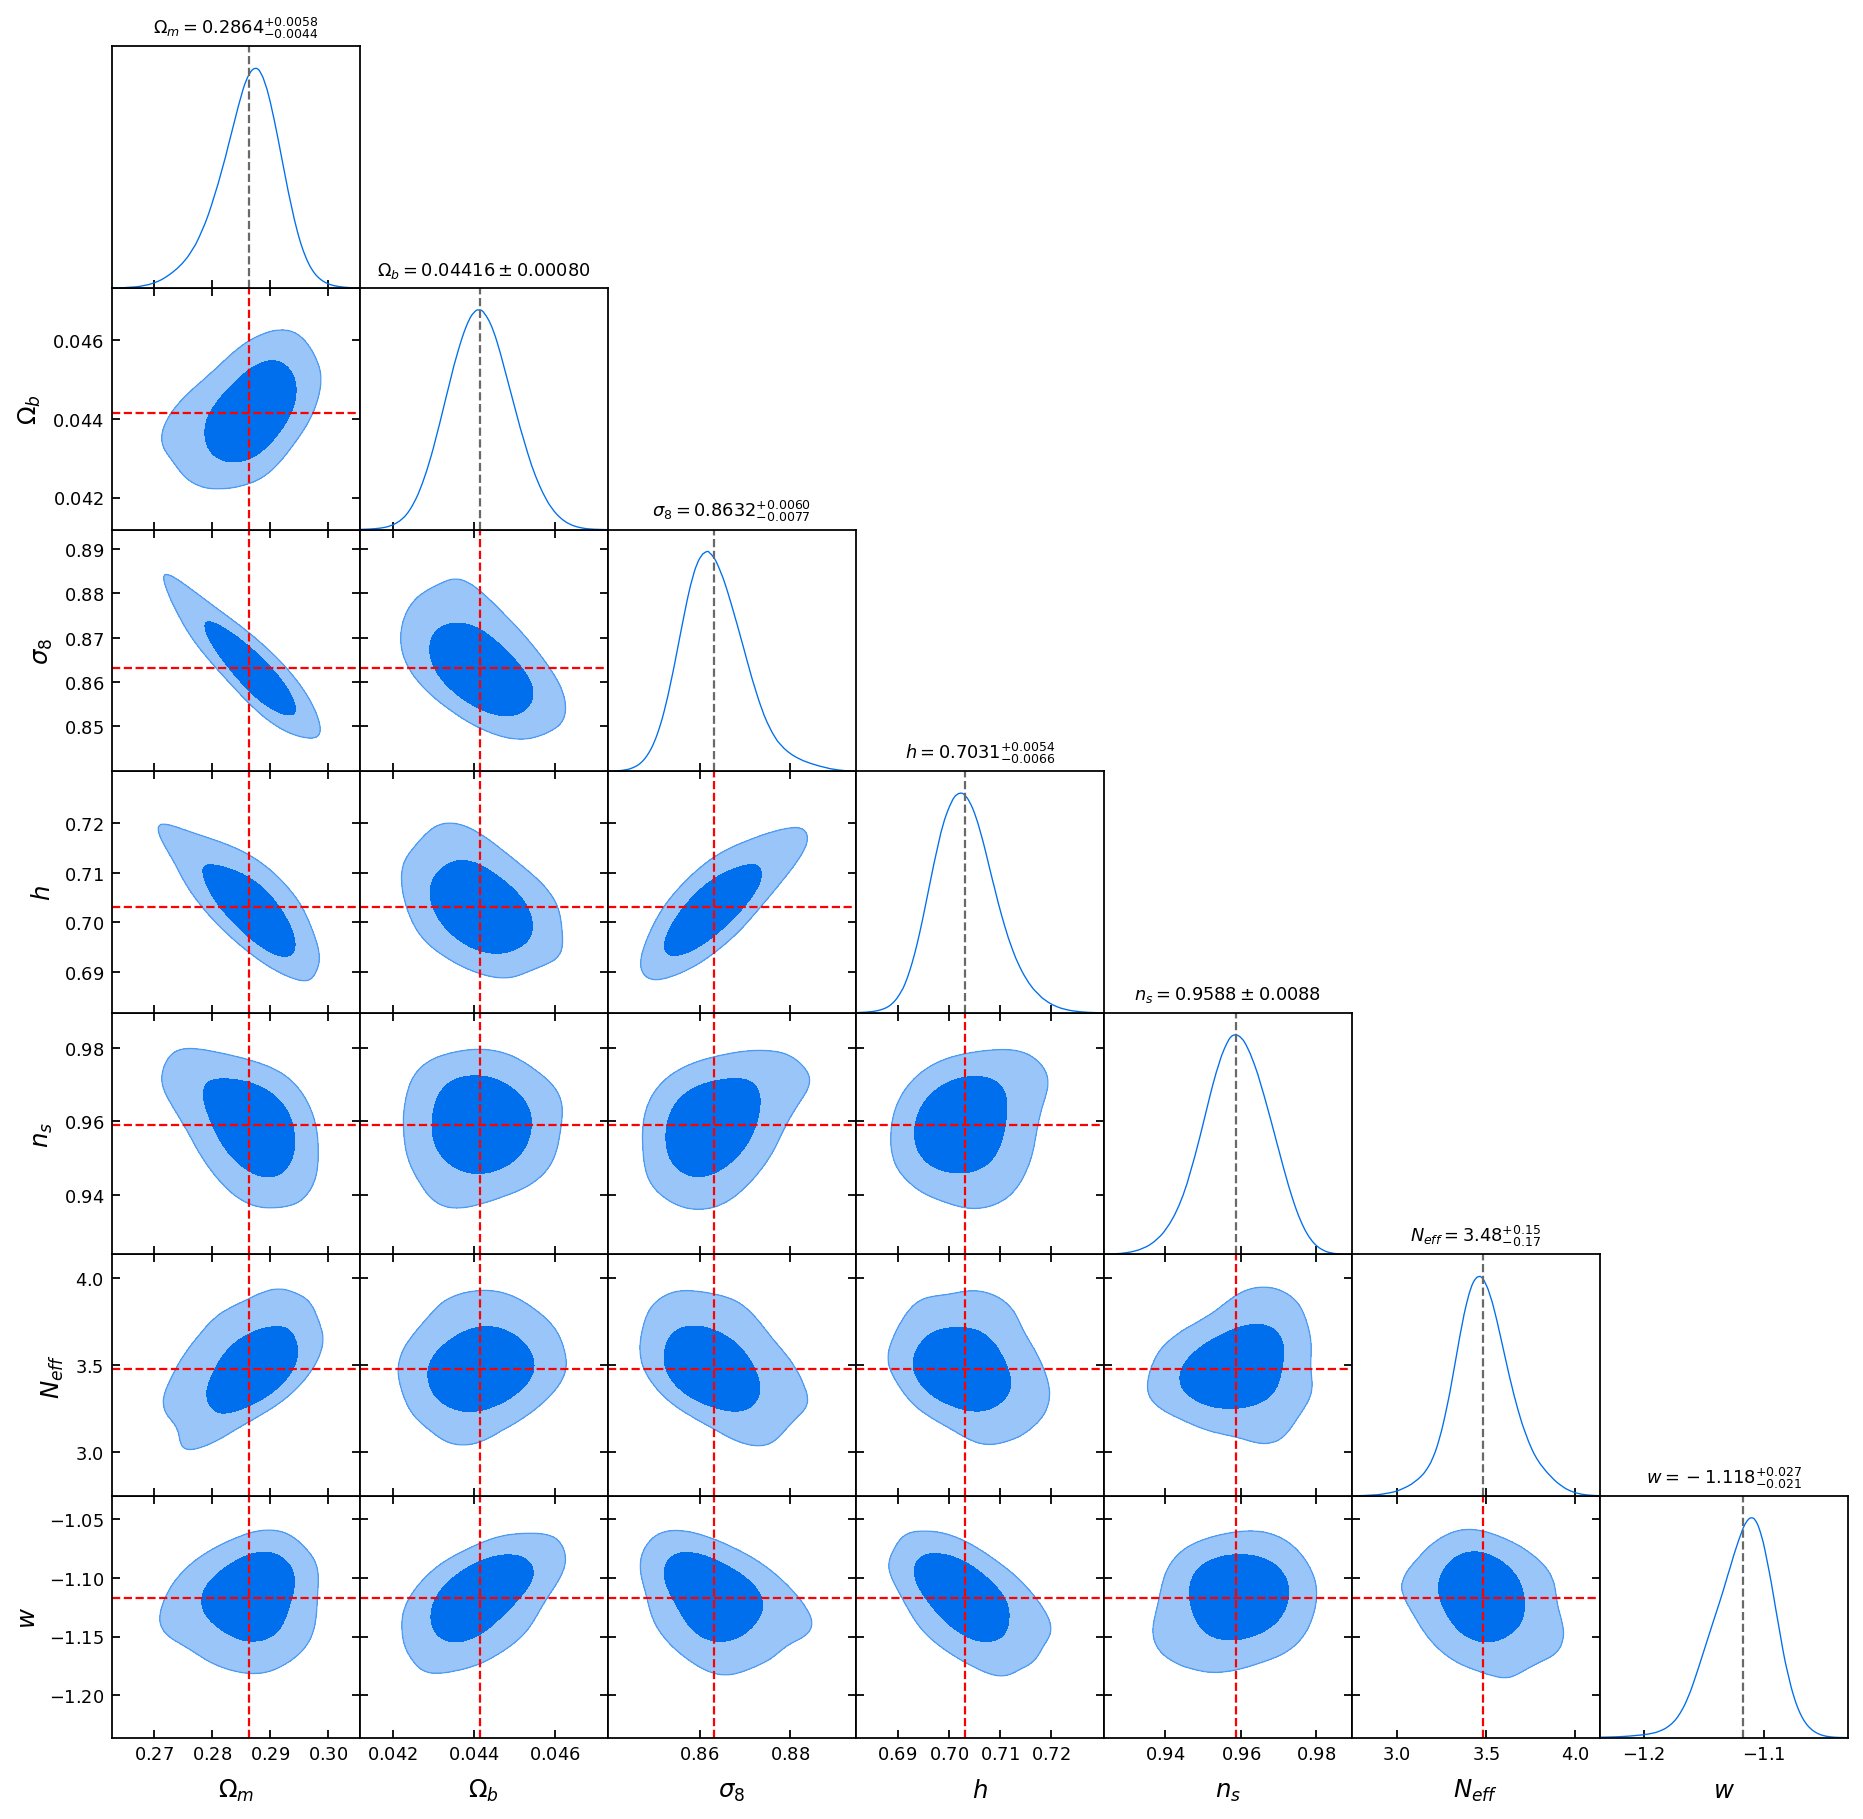

In [110]:
chaintag = 'wp_xi_upf_mcf_c3h3_allcosmo_dynesty_dlogz1e-2_nongen_hpriorg'
res = load_res(chaintag)
final_params = get_final_params(res)
mean_params = get_mean_posterior(res)
plot_contours_dynesty([chaintag], vertical_markers=mean_params)

In [112]:
print(mean_params)
chain_fn = f'../chains/chains_{chaintag}.h5'
fw = h5py.File(chain_fn, 'r')
print(fw.attrs['true_values'])
fw.close()

[ 0.28641261  0.0441555   0.86323397  0.70311264  0.95882229  3.48129814
 -1.11756982]
[ 0.289014   0.0434999  0.859613   0.707317   0.953515   3.7
 -1.13151  ]


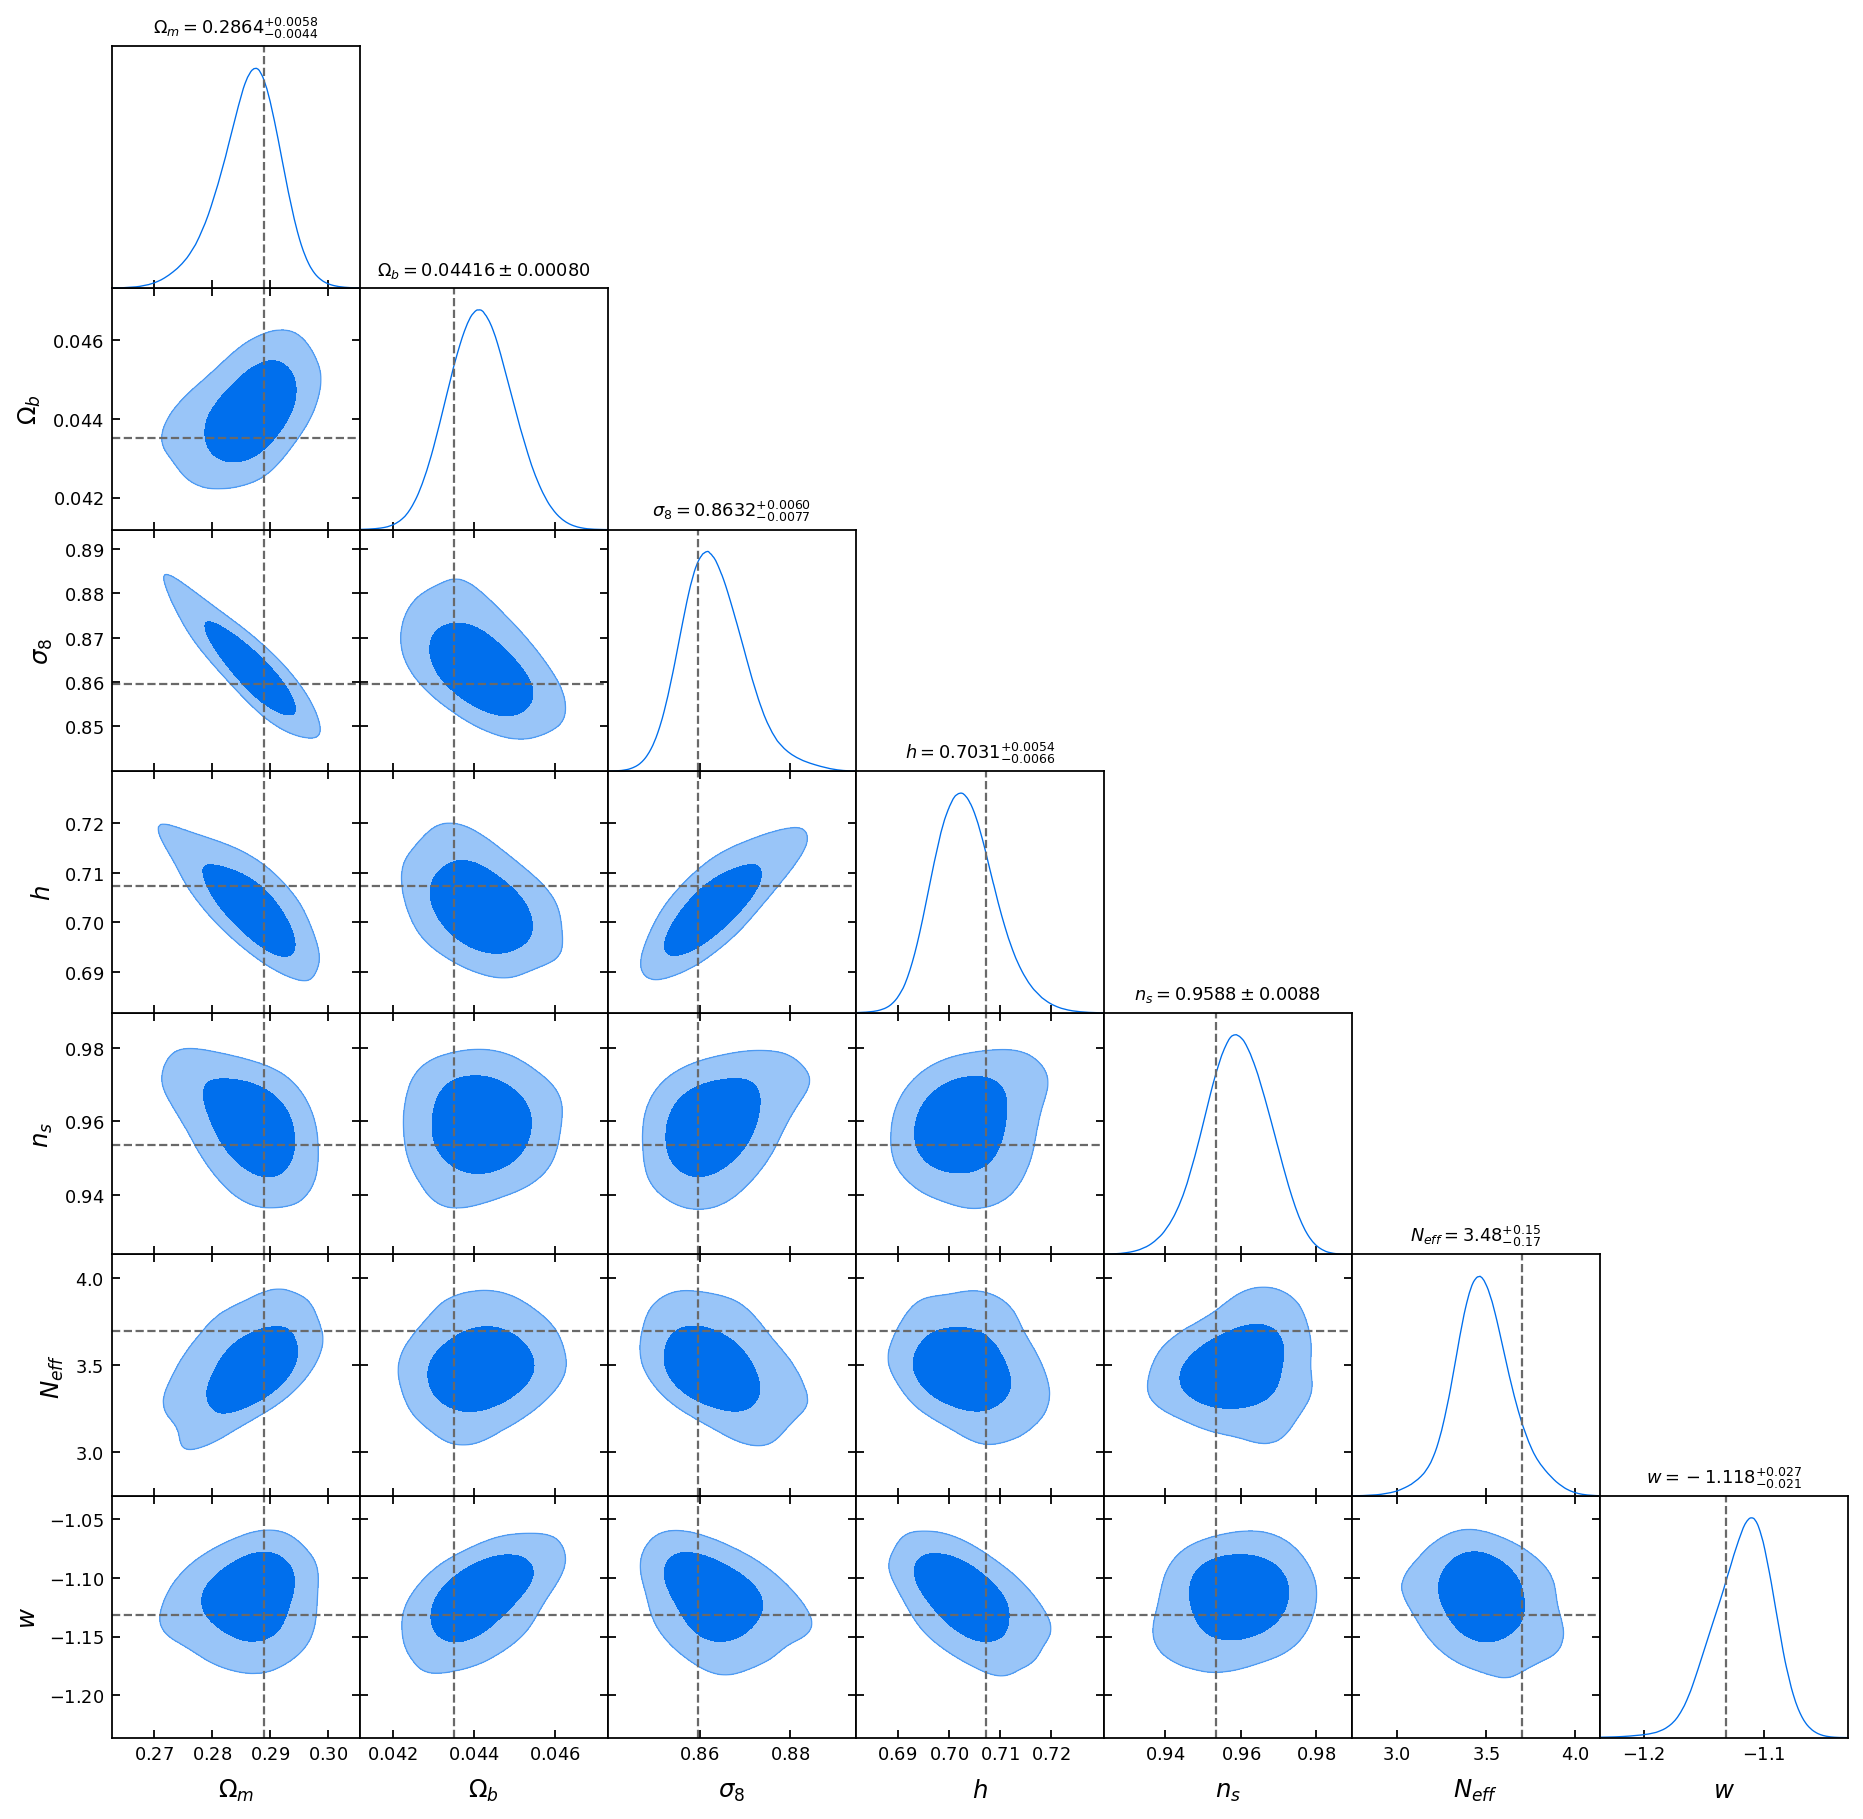

In [103]:
plot_contours_dynesty(['wp_xi_upf_mcf_c3h3_allcosmo_dynesty_dlogz1e-2_nongen_hpriorg'])

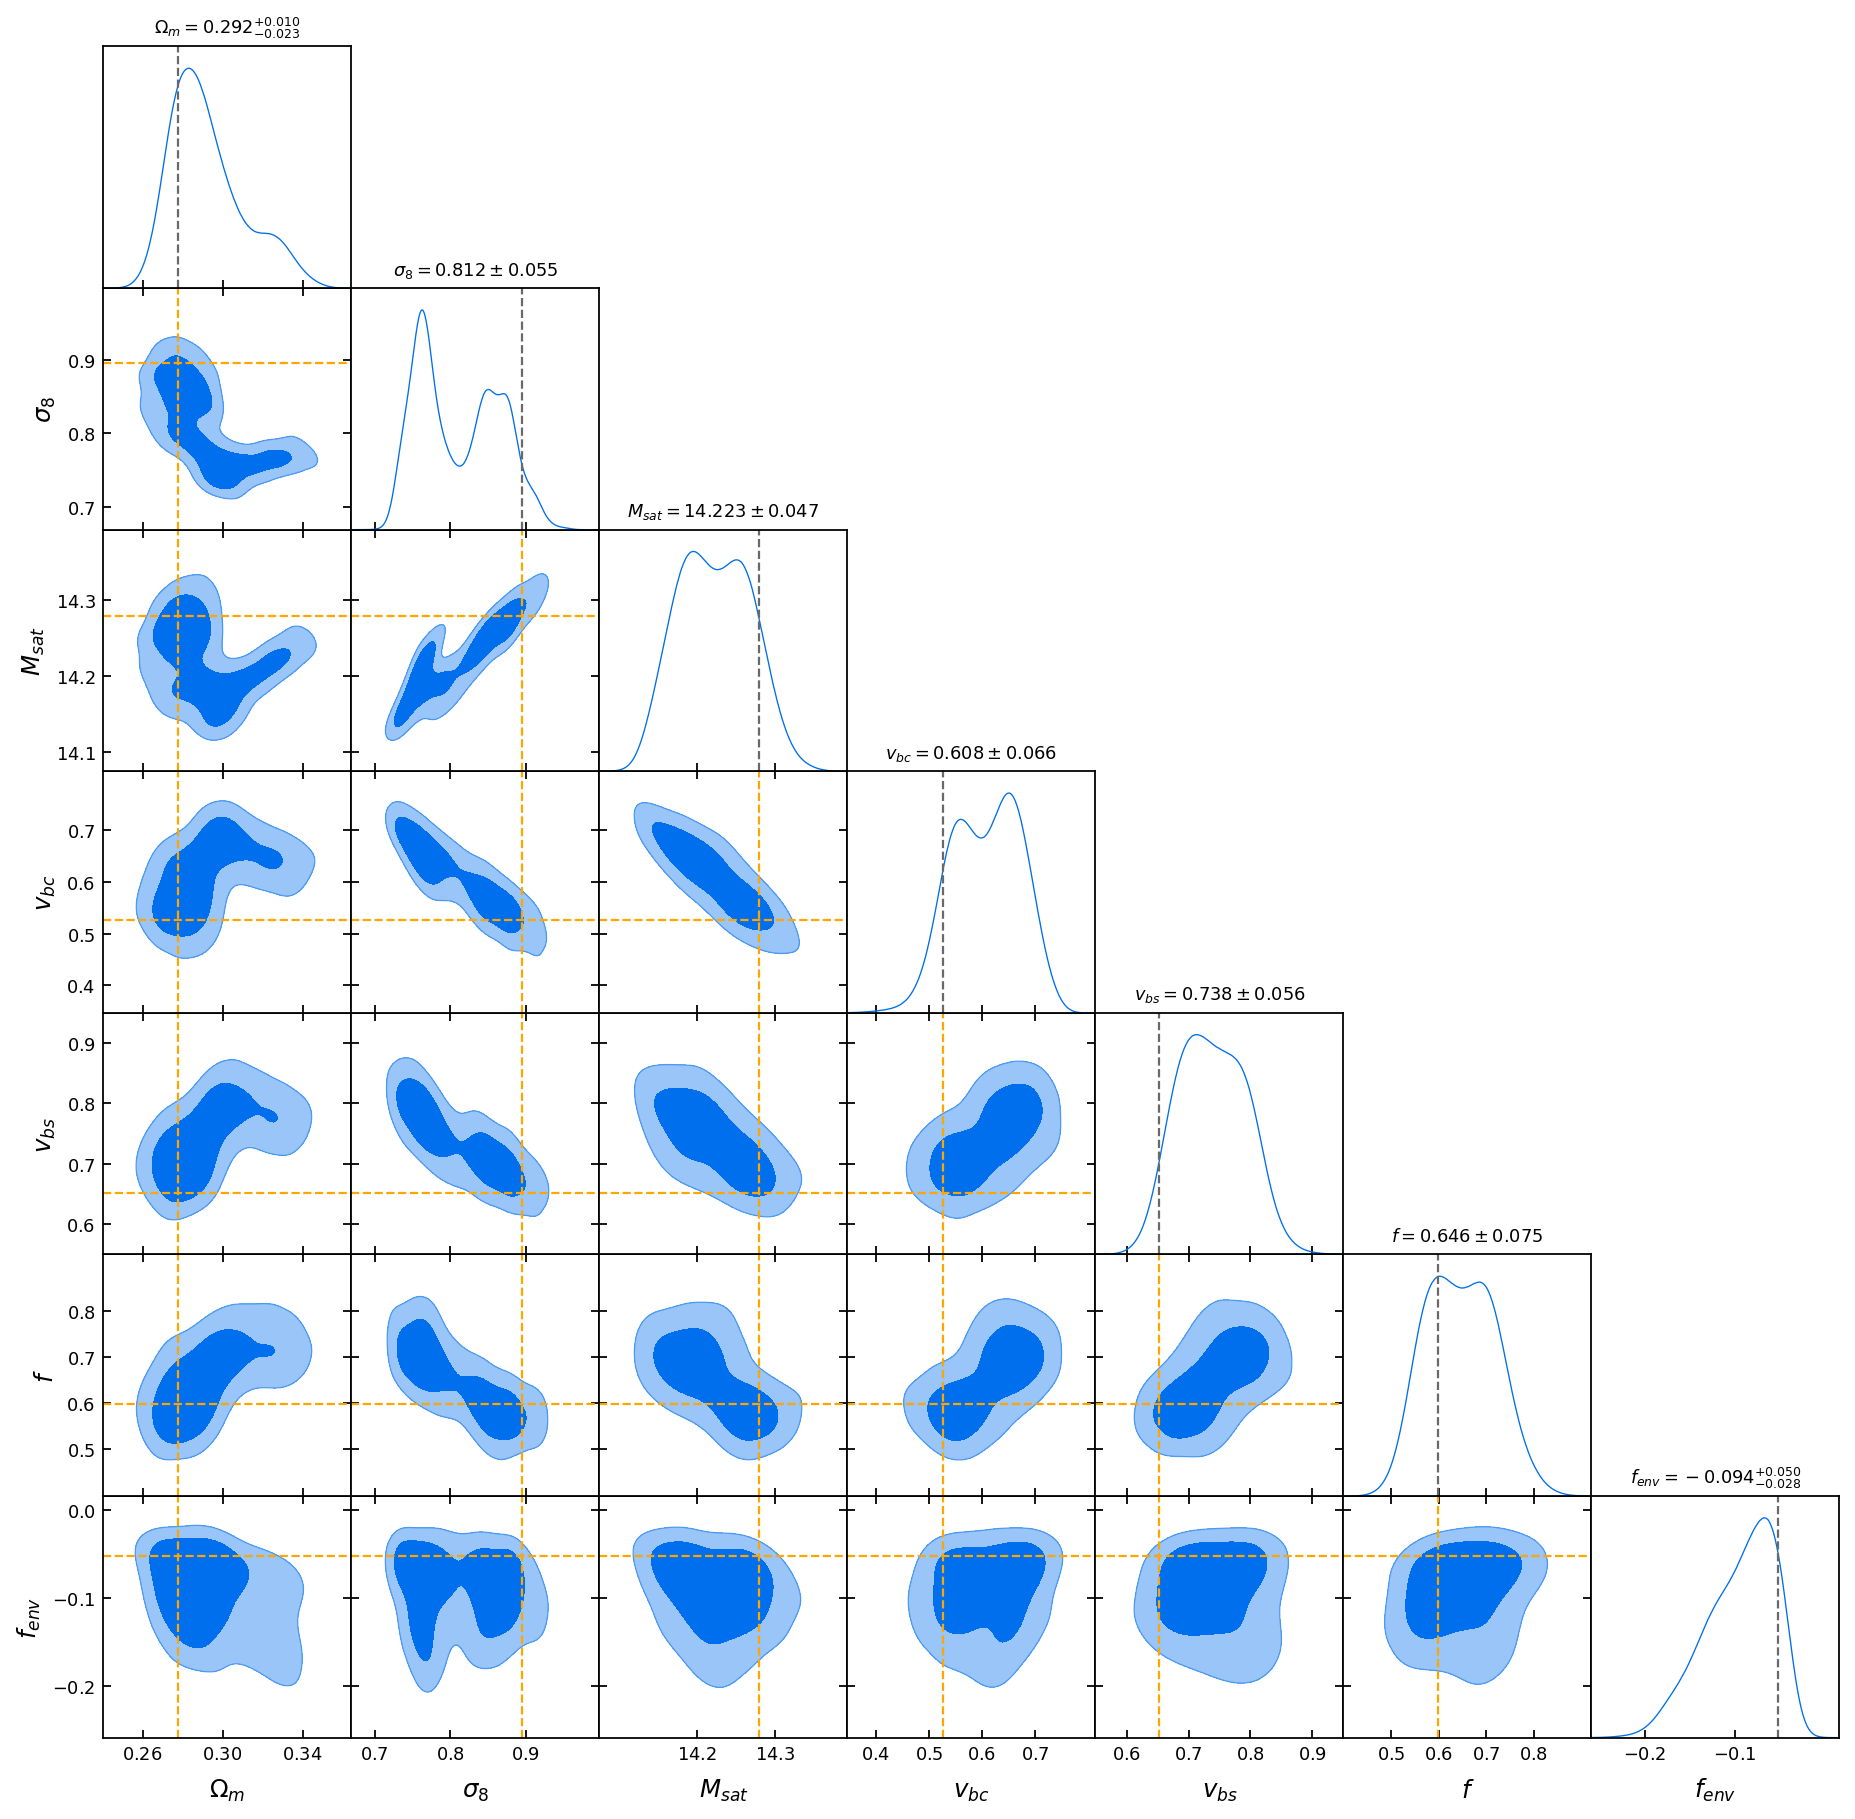

In [146]:
chaintag = 'wp_xi_upf_mcf_c3h3_all_dynesty_dlogz1e-2_nongen_hpriorg'
res = load_res(chaintag)
minlogl_params = get_minlogl_params(res, index=-1)
#mean_params = get_mean_posterior(res)
plot_contours_dynesty([chaintag], params_toplot=key_params, 
                      vertical_markers=minlogl_params, vertical_marker_color='orange')

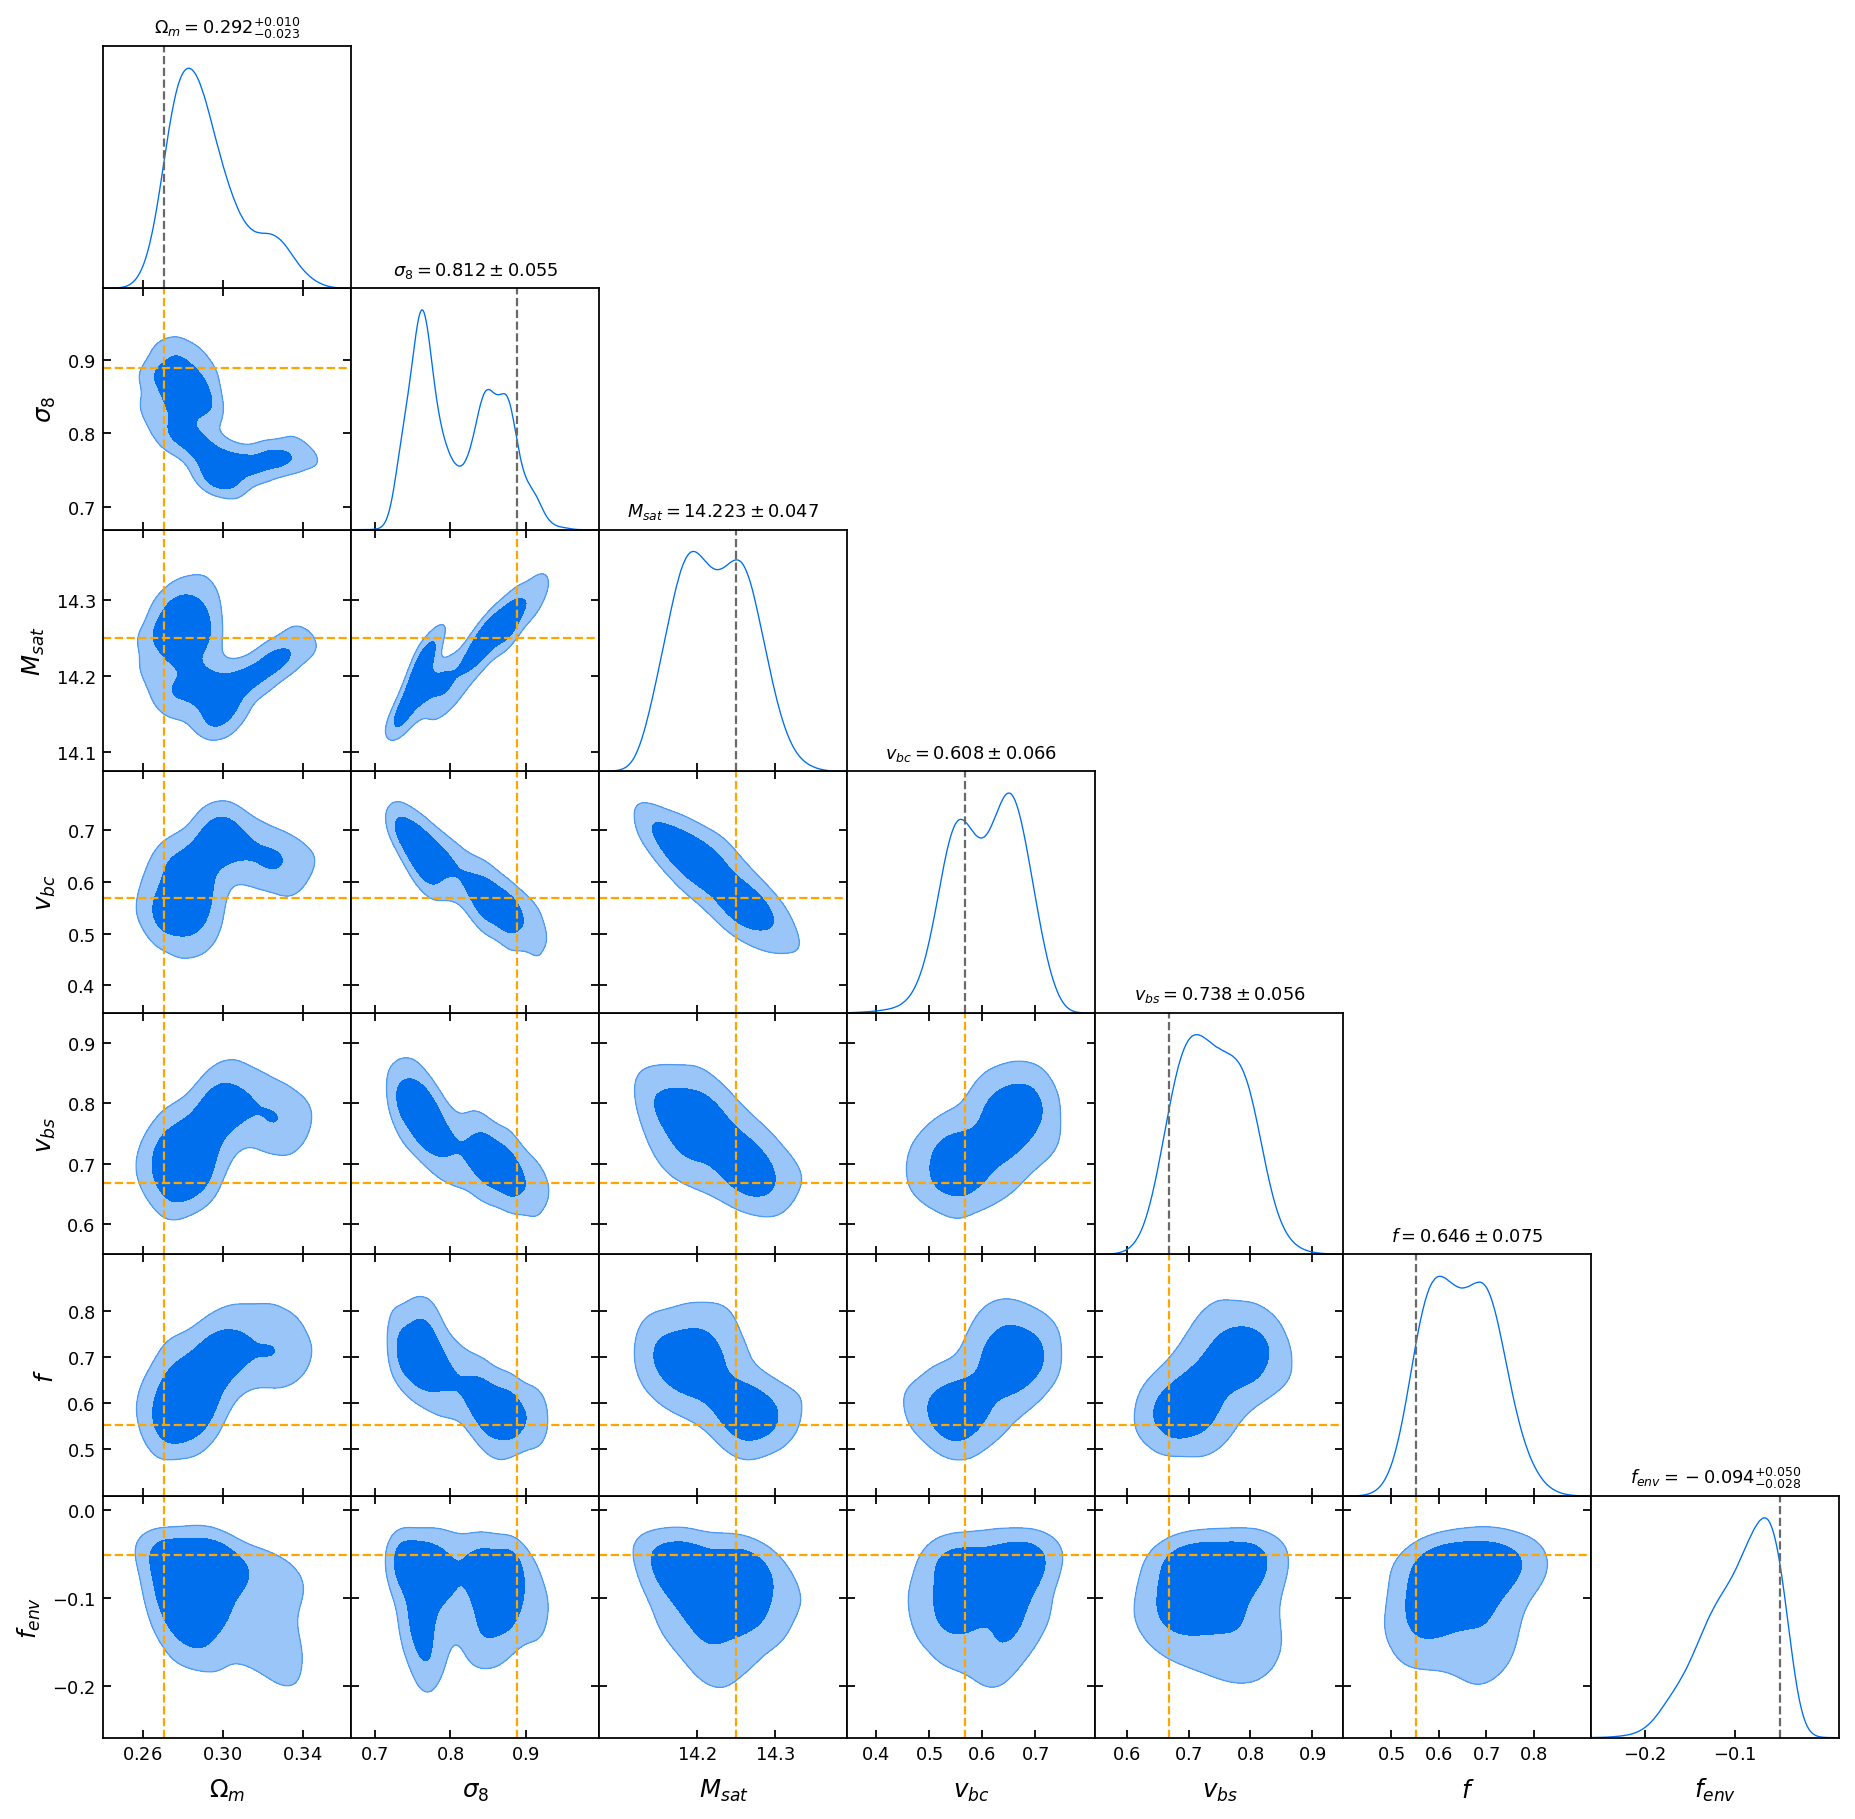

In [155]:
chaintag = 'wp_xi_upf_mcf_c3h3_all_dynesty_dlogz1e-2_nongen_hpriorg'
res = load_res(chaintag)
minlogl_params = get_minlogl_params(res, index=-2)
#mean_params = get_mean_posterior(res)
plot_contours_dynesty([chaintag], params_toplot=key_params, 
                      vertical_markers=minlogl_params, vertical_marker_color='orange')

Building emulators
george version: 0.3.1
Loading training data
Nparams: 18
Loading testing data
Nparams: 18
Rebuilding emulators
Emulator for wp built
george version: 0.3.1
Loading training data
Nparams: 18
Loading testing data
Nparams: 18
Rebuilding emulators
Emulator for xi built
george version: 0.3.1
Loading training data
Nparams: 18
Loading testing data
Nparams: 18
Rebuilding emulators
Emulator for upf built
george version: 0.3.1
Loading training data
Nparams: 18
Loading testing data
Nparams: 18
Rebuilding emulators
Emulator for mcf built


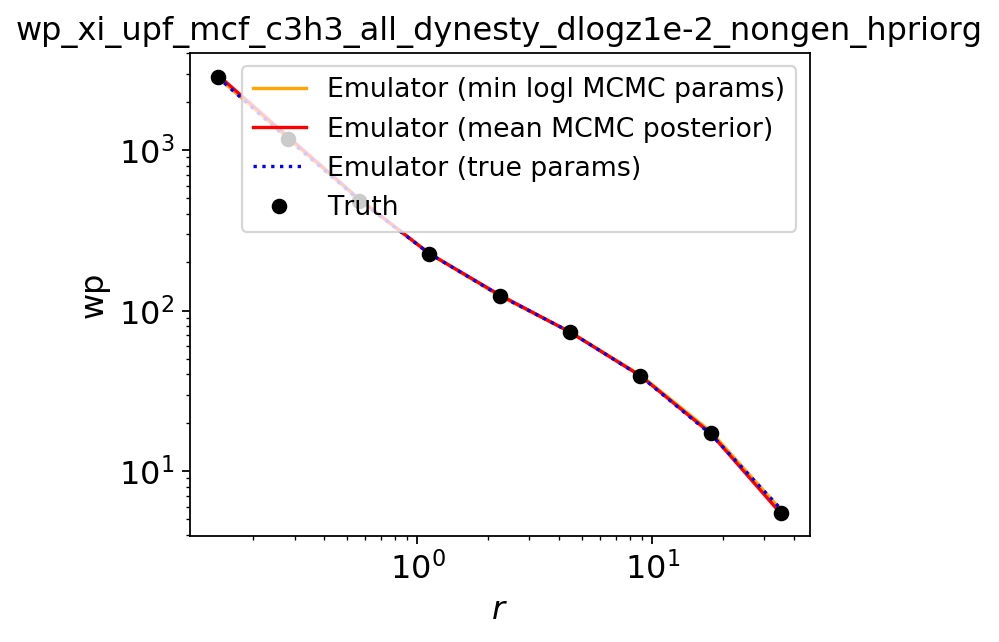

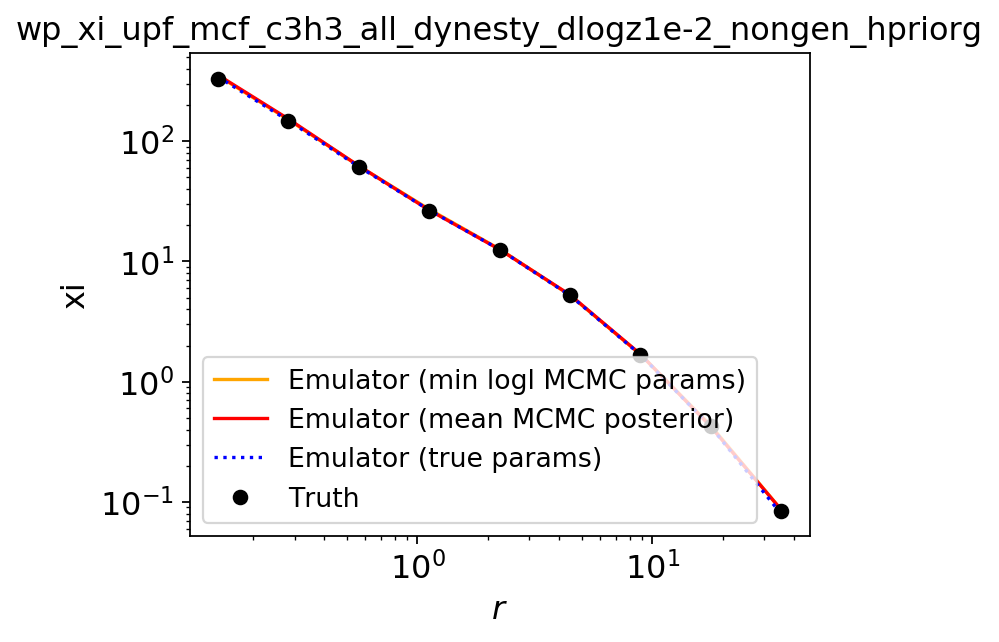

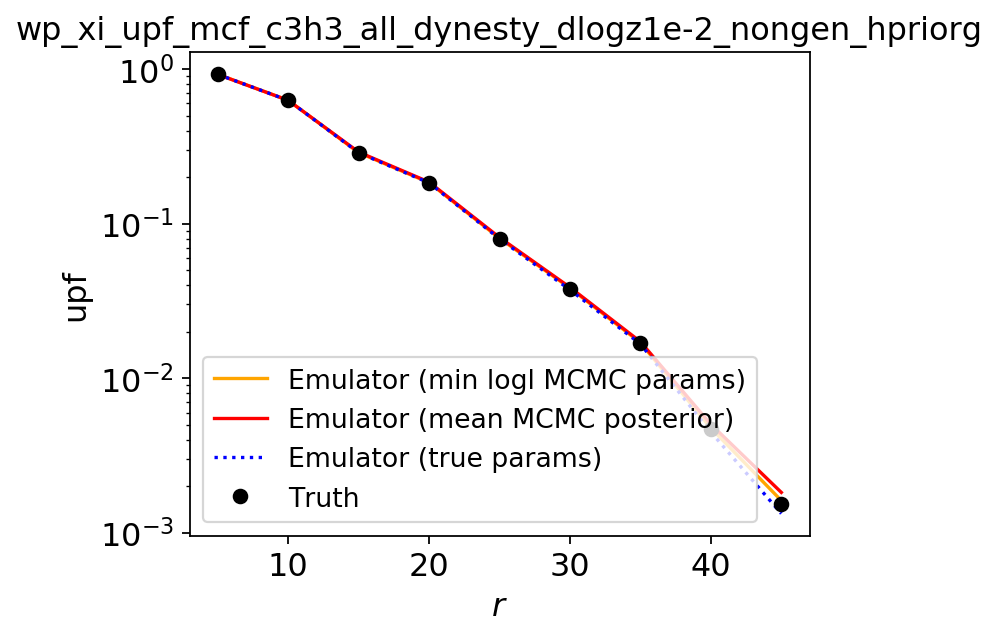

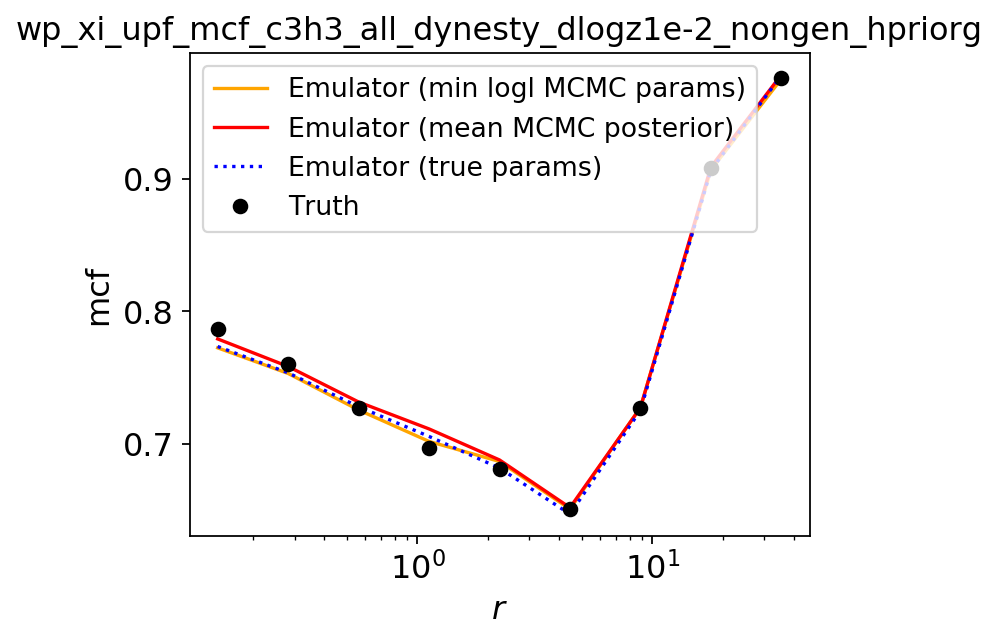

In [153]:
chaintag = 'wp_xi_upf_mcf_c3h3_all_dynesty_dlogz1e-2_nongen_hpriorg'
fits = get_fits(chaintag)
plot_fits(*fits, title=chaintag)

In [ ]:
chaintag = 'wp_xi_upf_mcf_c3h3_all_dynesty_dlogz1e-2_nongen_hpriorg'
res = load_res(chaintag)
minlogl_params = get_minlogl_params(res, index=-2)
#mean_params = get_mean_posterior(res)
plot_contours_dynesty([chaintag], params_toplot=key_params, 
                      vertical_markers=minlogl_params, vertical_marker_color='limegreen')

-8959818.87929685 -8.898950471368908
(49532, 18)


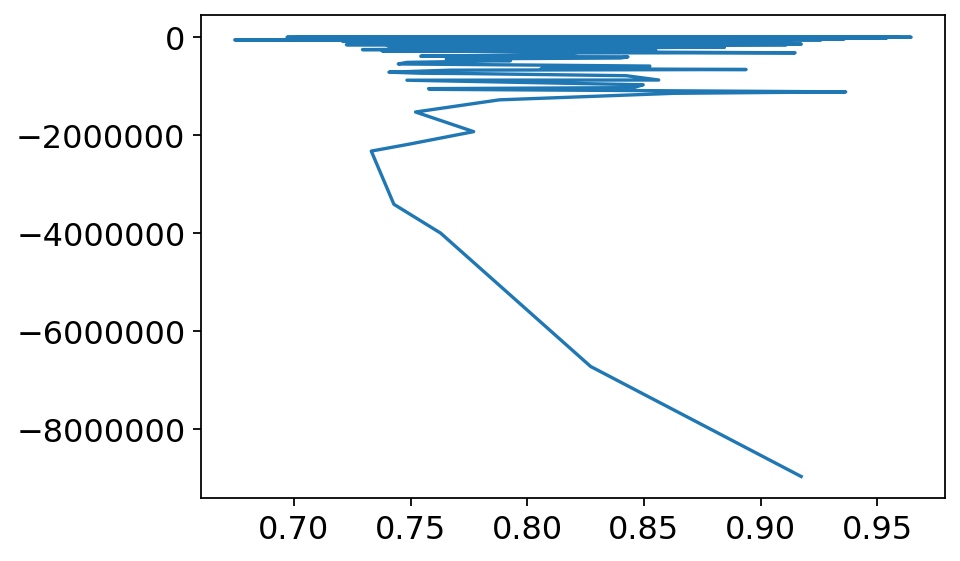

In [124]:
chaintag = 'wp_xi_upf_mcf_c3h3_all_dynesty_dlogz1e-2_nongen_hpriorg'
res = load_res(chaintag)
samples = res['samples']
logl = res['logl']
print(min(res['logl']), max(res['logl']))

lnweight = np.array(res['logwt'])
lnevidence = np.array(res['logz'])
#[-1] bc just care about final evidence value
weights = np.exp(lnweight - lnevidence[-1]) 
#weights = weights.flatten()
samples_equal = dynesty.utils.resample_equal(samples, weights)
print(samples_equal.shape)
sigma8 = samples_equal[:,2]

plt.plot(sigma8, logl)

-5714934.842925123 -0.15971823985930028


Text(0, 0.5, '\\sigma_8')

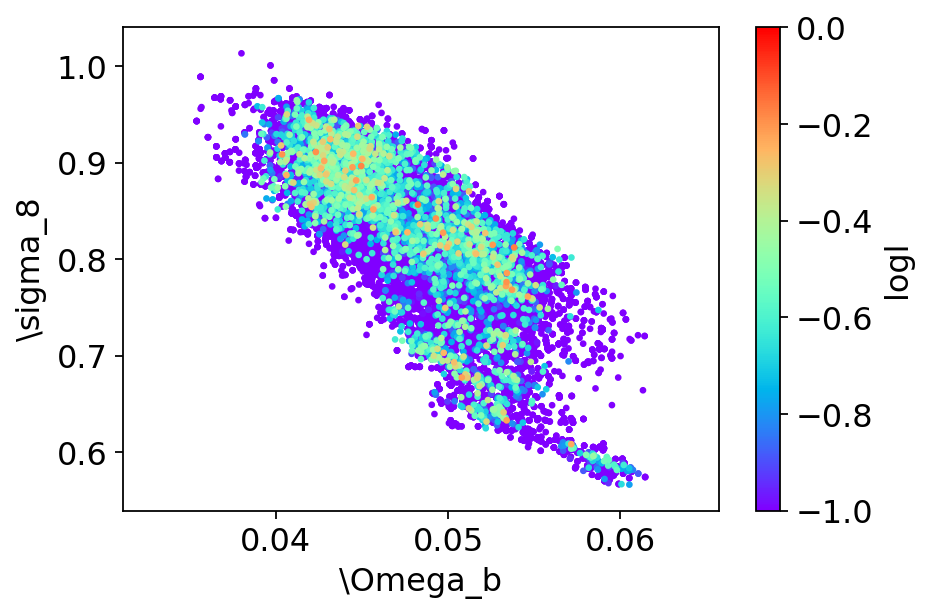

In [230]:
#chaintag = 'wp_xi_upf_mcf_c3h3_all_dynesty_dlogz1e-2_nongen_hpriorg'
chaintag = 'wp_c3h3_all_dynesty_dlogz1e-2_nongen_hpriorg'


res = load_res(chaintag)
samples = res['samples']
logl = res['logl']
print(min(res['logl']), max(res['logl']))

lnweight = np.array(res['logwt'])
lnevidence = np.array(res['logz'])
#[-1] bc just care about final evidence value
weights = np.exp(lnweight - lnevidence[-1]) 
samples_equal = dynesty.utils.resample_equal(samples, weights)
omegam = samples_equal[:,1]
sigma8 = samples_equal[:,2]


colormap = plt.cm.rainbow #or any other colormap
normalize = matplotlib.colors.Normalize(vmin=-1, vmax=0)
#normalize = matplotlib.colors.Normalize(vmin=min(res['logl']), vmax=max(res['logl']))
sm = plt.cm.ScalarMappable(cmap=colormap, norm=normalize)
plt.scatter(omegam, sigma8, c=logl, s=4, cmap=colormap, norm=normalize)
plt.colorbar(sm, label='logl')
#plt.scatter(x, y, c=z, s=5, cmap=colormap, norm=normalize, marker='*')
plt.xlabel(param_labels['Omega_b'])
plt.ylabel(param_labels['sigma_8'])

In [142]:
print(logl[-1])
print(logl[-10:])

-0.15971823985930028
[-0.20847022 -0.20599108 -0.20514887 -0.19885693 -0.19368909 -0.19275629
 -0.19219784 -0.17533104 -0.1644477  -0.15971824]


In [140]:
samples[-8:,2]

array([0.78068935, 0.77896679, 0.81229166, 0.77838933, 0.91760676,
       0.81247715, 0.88951465, 0.85660816])

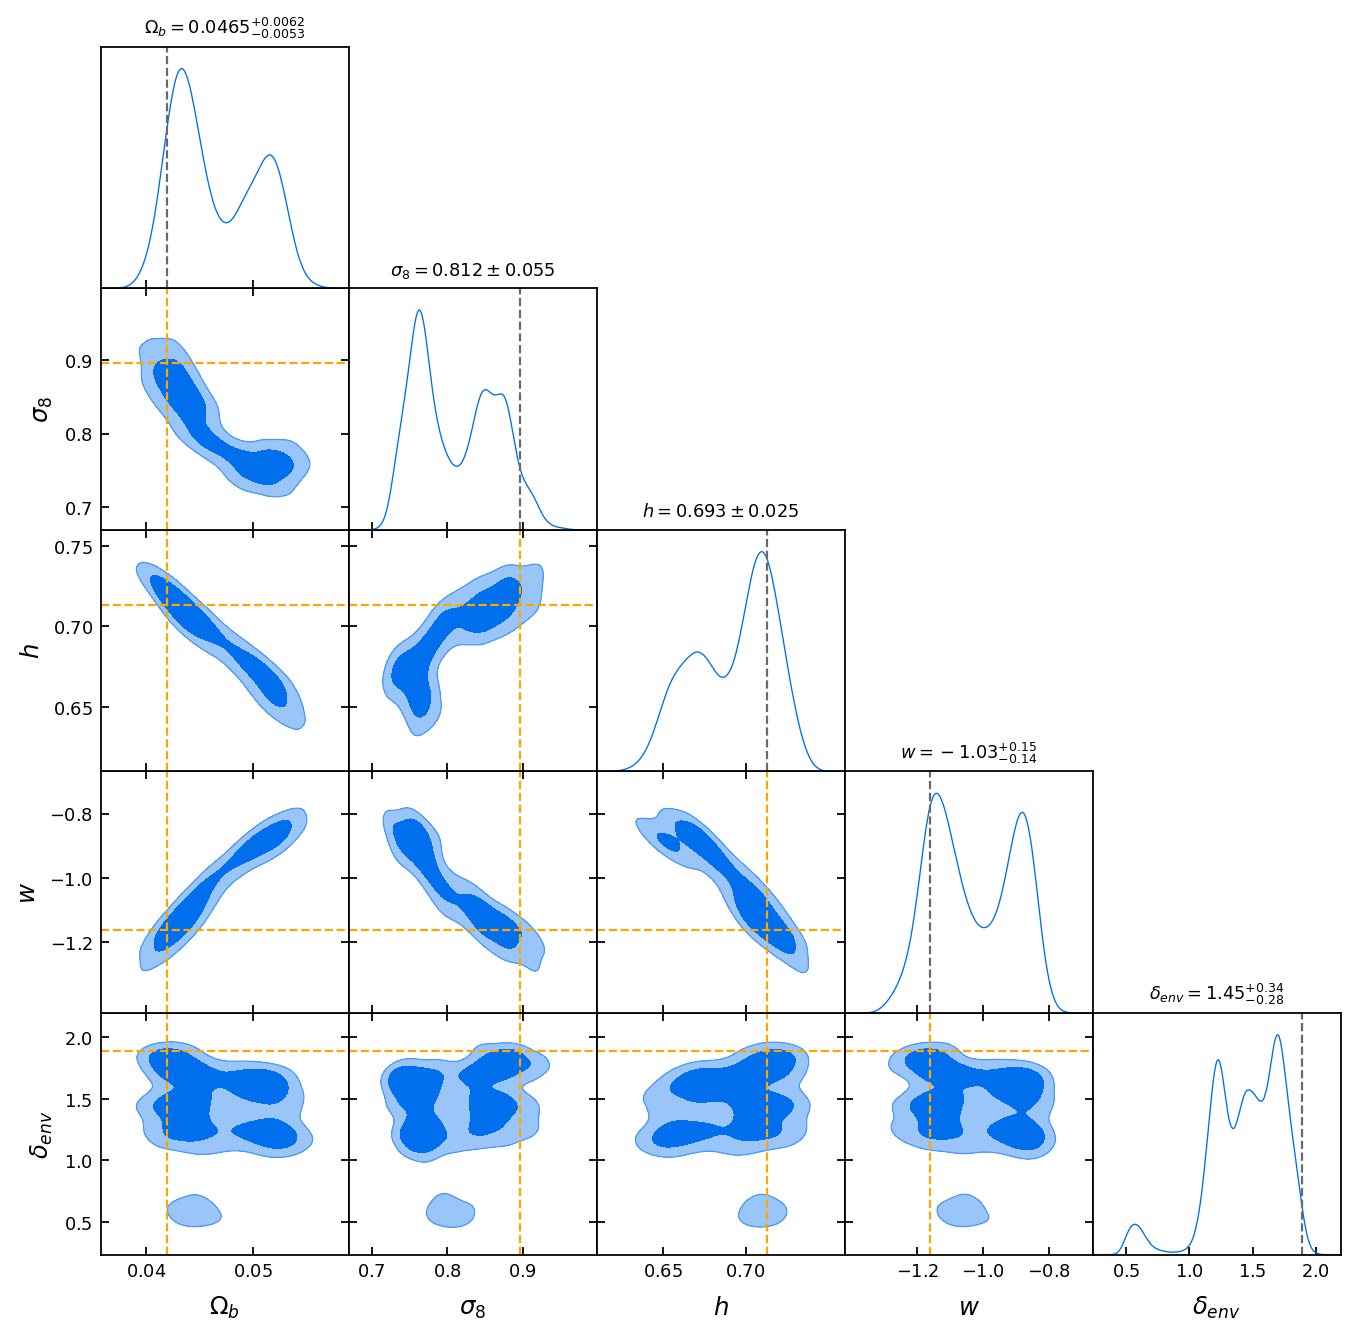

In [168]:
chaintag = 'wp_xi_upf_mcf_c3h3_all_dynesty_dlogz1e-2_nongen_hpriorg'
res = load_res(chaintag)
minlogl_params = get_minlogl_params(res, index=-1)
plot_contours_dynesty([chaintag], params_toplot=bi_params, 
                      vertical_markers=minlogl_params, vertical_marker_color='orange')

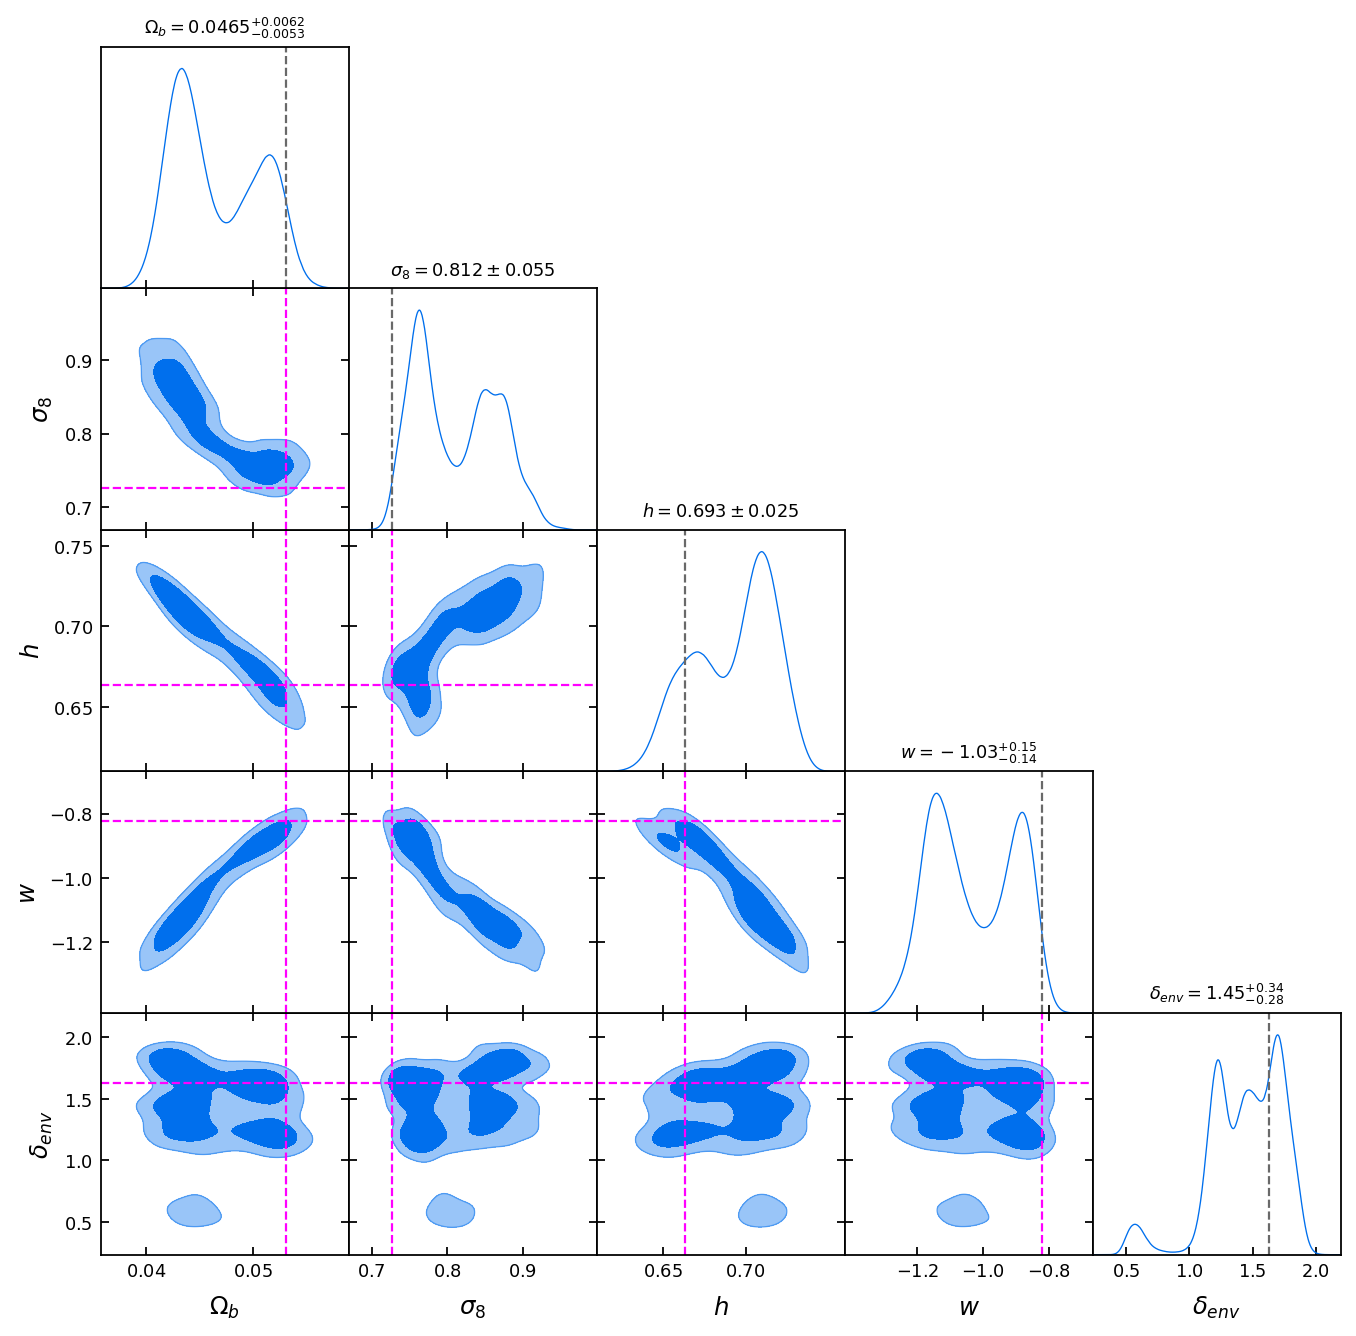

In [178]:
chaintag = 'wp_xi_upf_mcf_c3h3_all_dynesty_dlogz1e-2_nongen_hpriorg'
res = load_res(chaintag)
minlogl_params = get_minlogl_params(res, index=-19)
plot_contours_dynesty([chaintag], params_toplot=bi_params, 
                      vertical_markers=minlogl_params, vertical_marker_color='magenta')

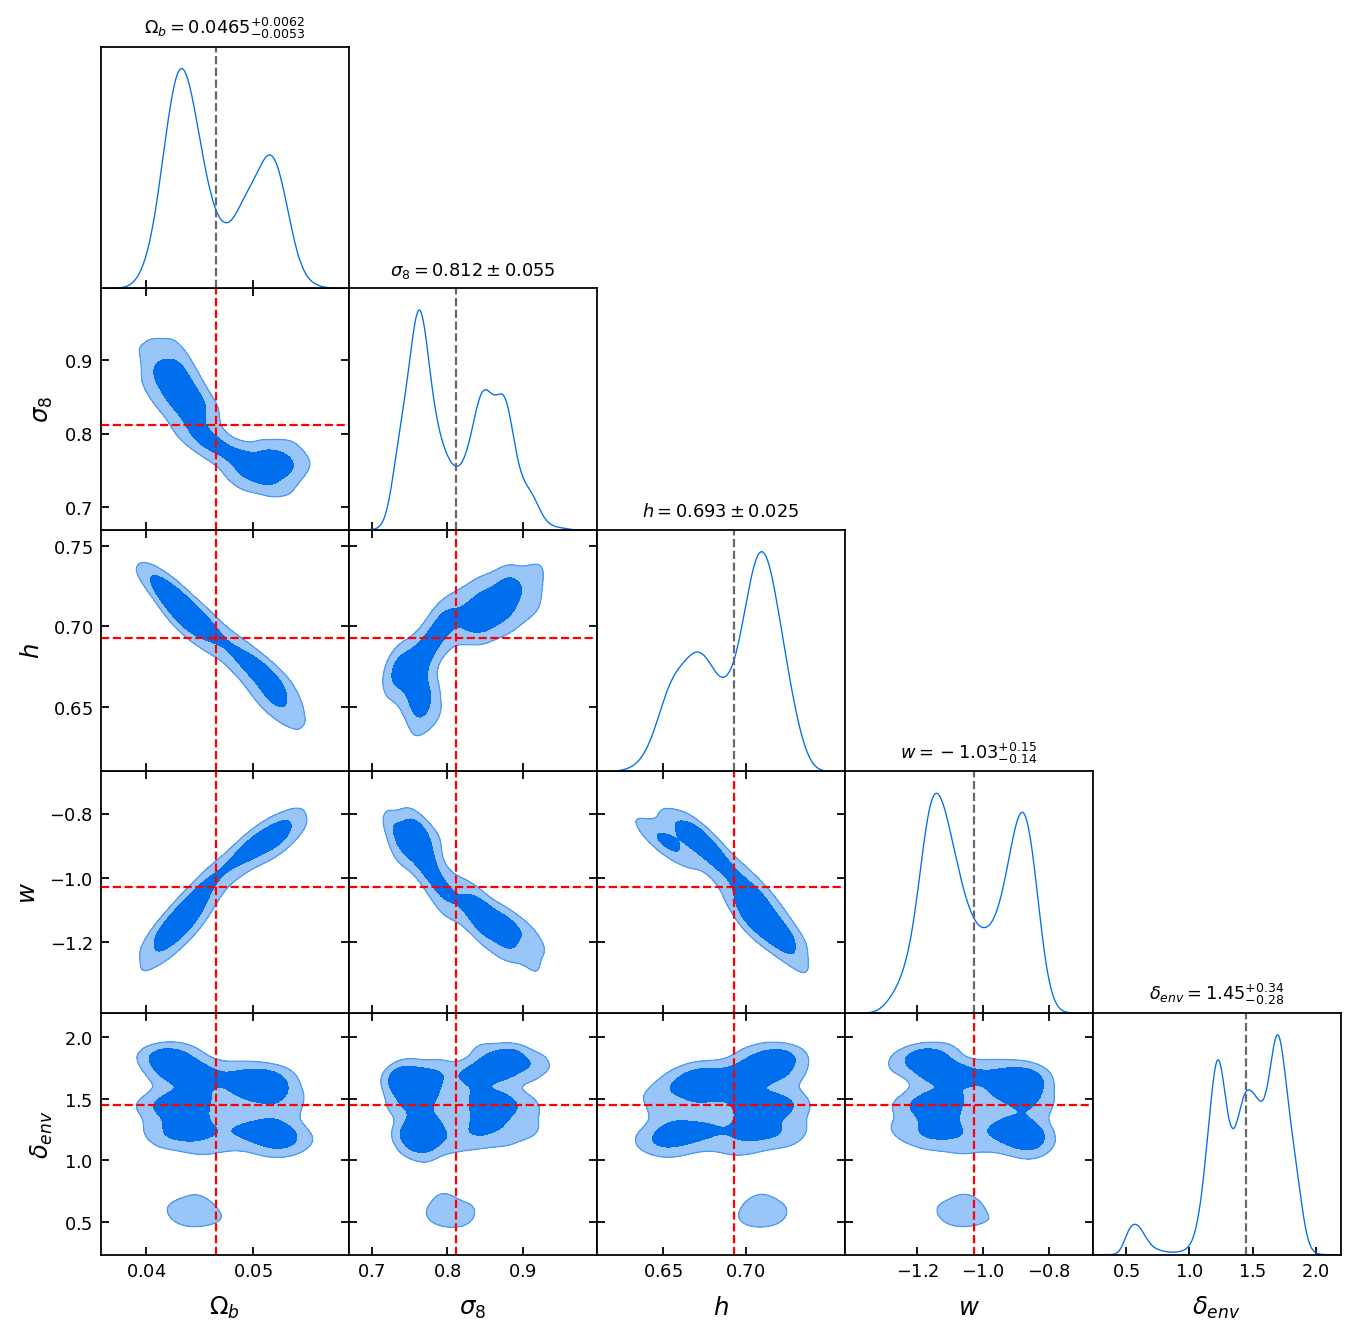

In [208]:
chaintag = 'wp_xi_upf_mcf_c3h3_all_dynesty_dlogz1e-2_nongen_hpriorg'
res = load_res(chaintag)
mean_params = get_mean_params(res)
plot_contours_dynesty([chaintag], params_toplot=bi_params, 
                      vertical_markers=mean_params, vertical_marker_color='red')

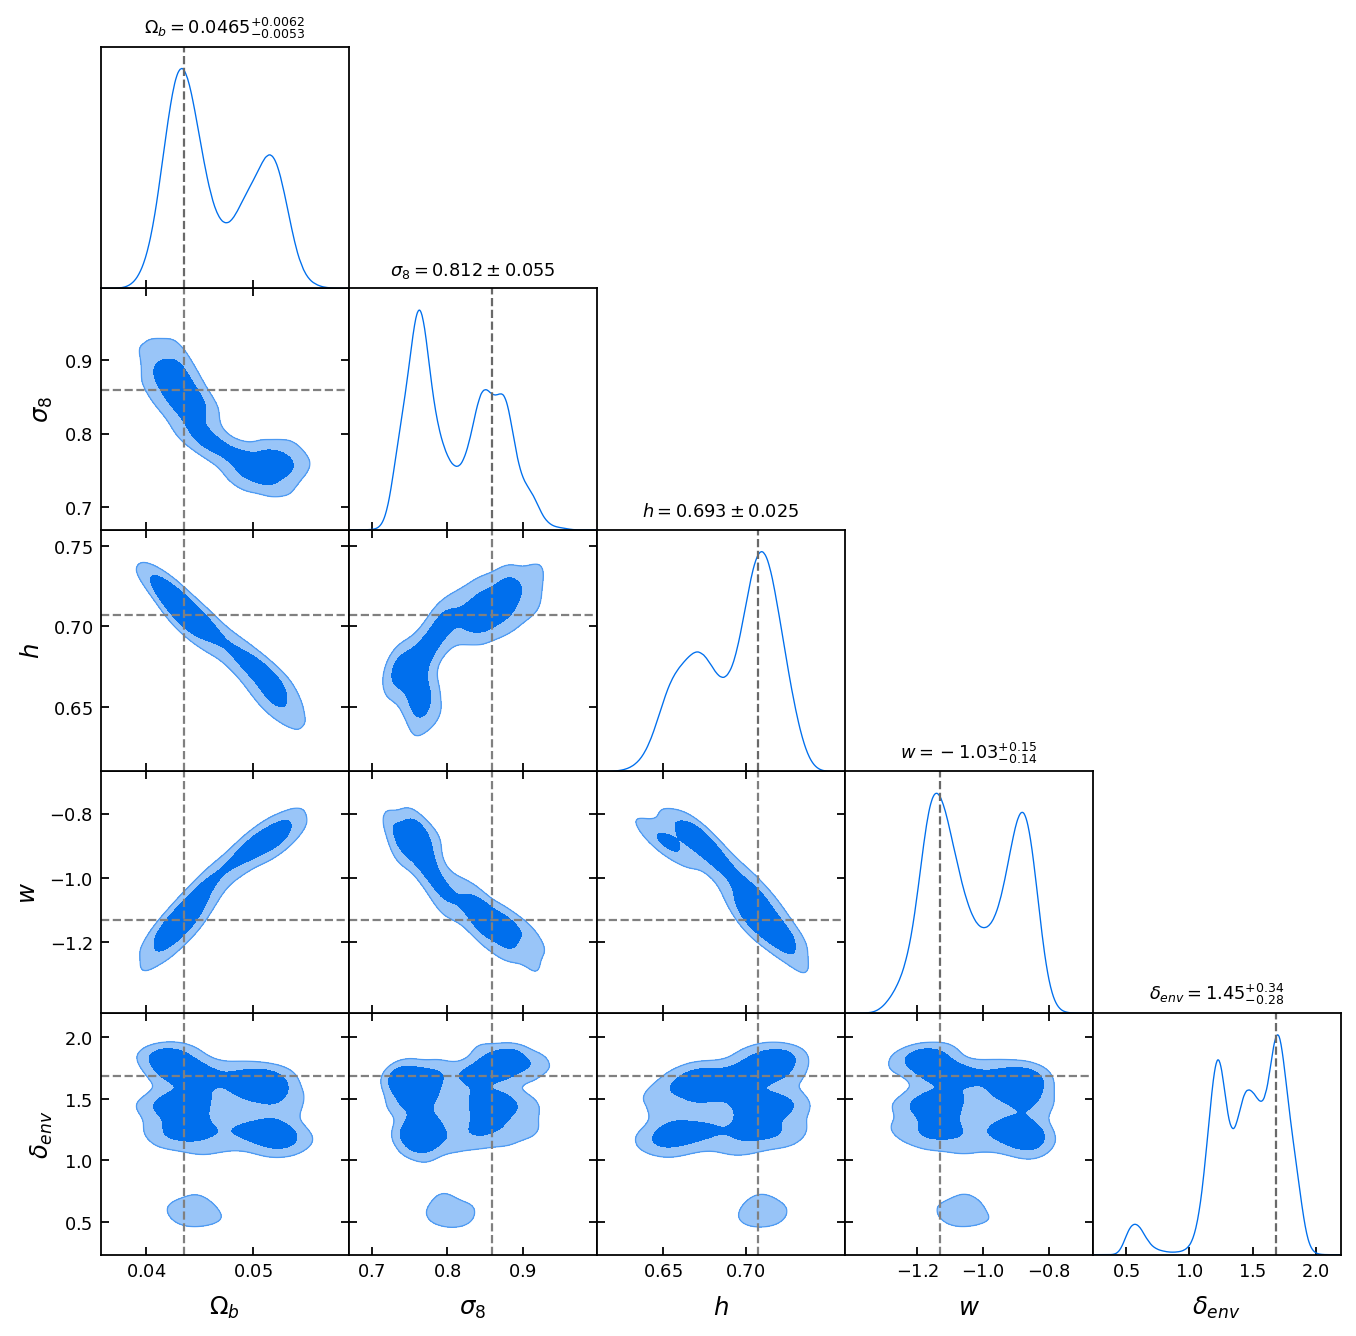

In [216]:
chaintag = 'wp_xi_upf_mcf_c3h3_all_dynesty_dlogz1e-2_nongen_hpriorg'
res = load_res(chaintag)
true_params = get_true_params(chaintag)
plot_contours_dynesty([chaintag], params_toplot=bi_params, 
                      vertical_markers=true_params, vertical_marker_color='grey')

In [209]:
chaintag = 'wp_xi_upf_mcf_c3h3_all_dynesty_dlogz1e-2_nongen_hpriorg'
minlogl_params1 = get_minlogl_params(res, index=-1)
minlogl_params19 = get_minlogl_params(res, index=-19)
mean_params = get_mean_params(res)
true_params = get_true_params(chaintag)
param_arr = [true_params, mean_params, minlogl_params1, minlogl_params19]
fit_labels = ['Emulator (true params)', 'Emulator (mean params)', 'Emulator (params from mode 1)', 'Emulator (params from mode 2)']
statistics, vals_arr_all, fit_labels = get_fits(chaintag, param_arr, fit_labels)

Building emulators
Rebuilding emulator for wp
Rebuilding emulator for xi
Rebuilding emulator for upf
Rebuilding emulator for mcf


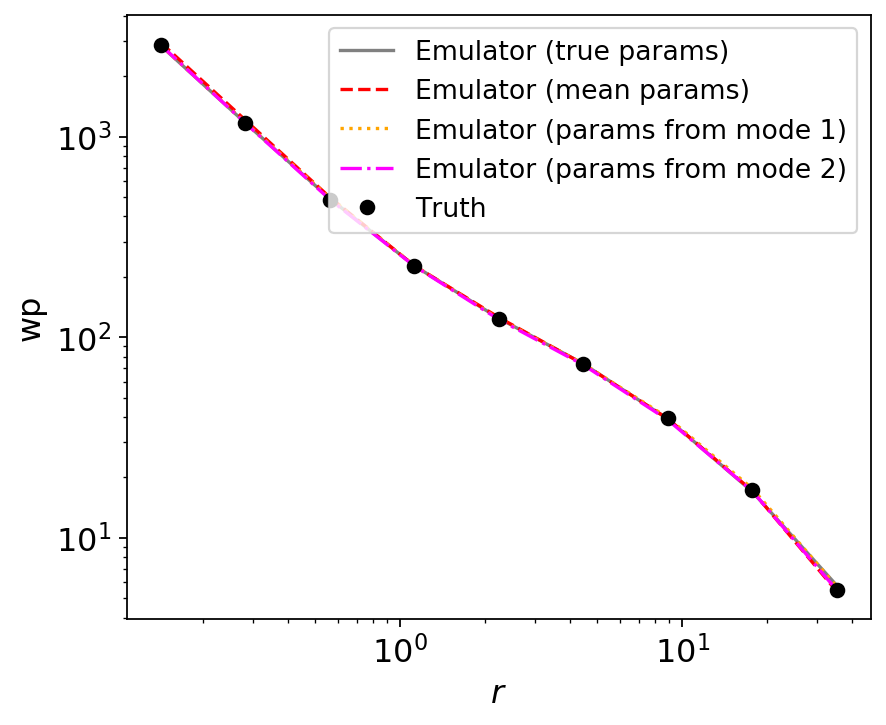

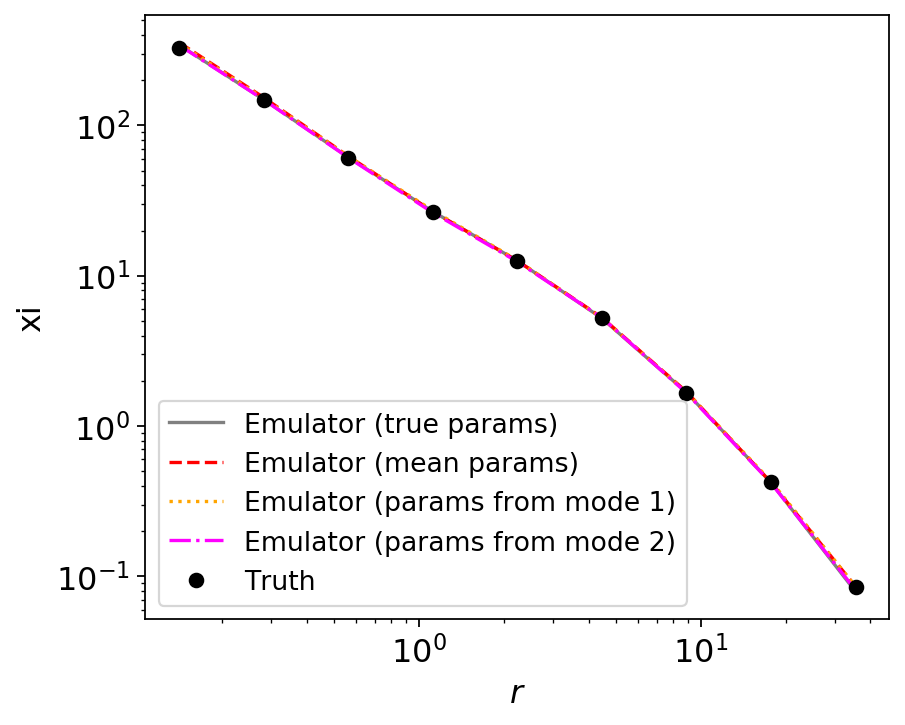

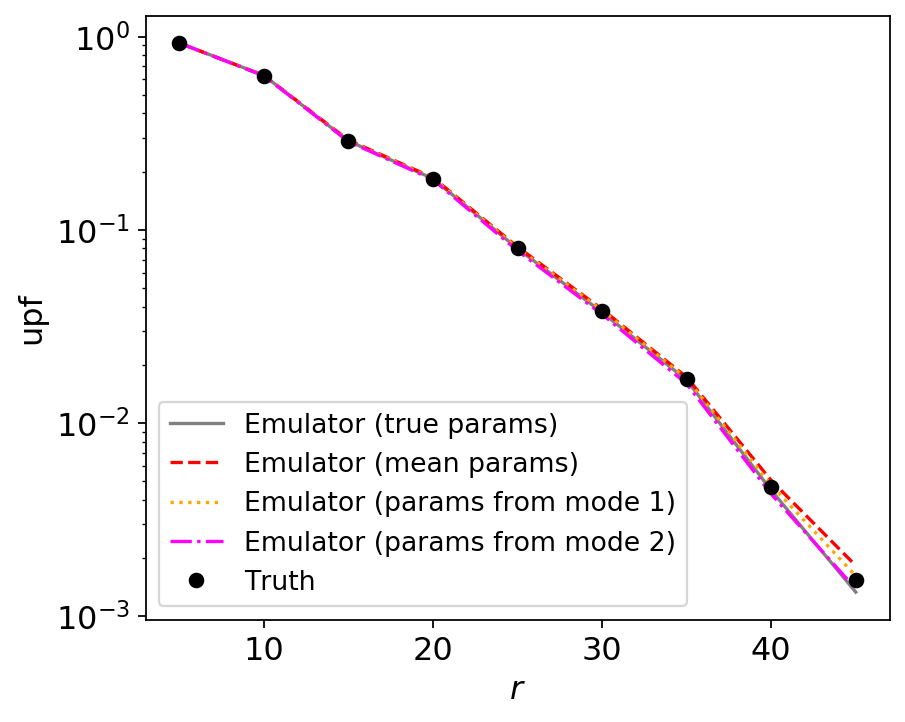

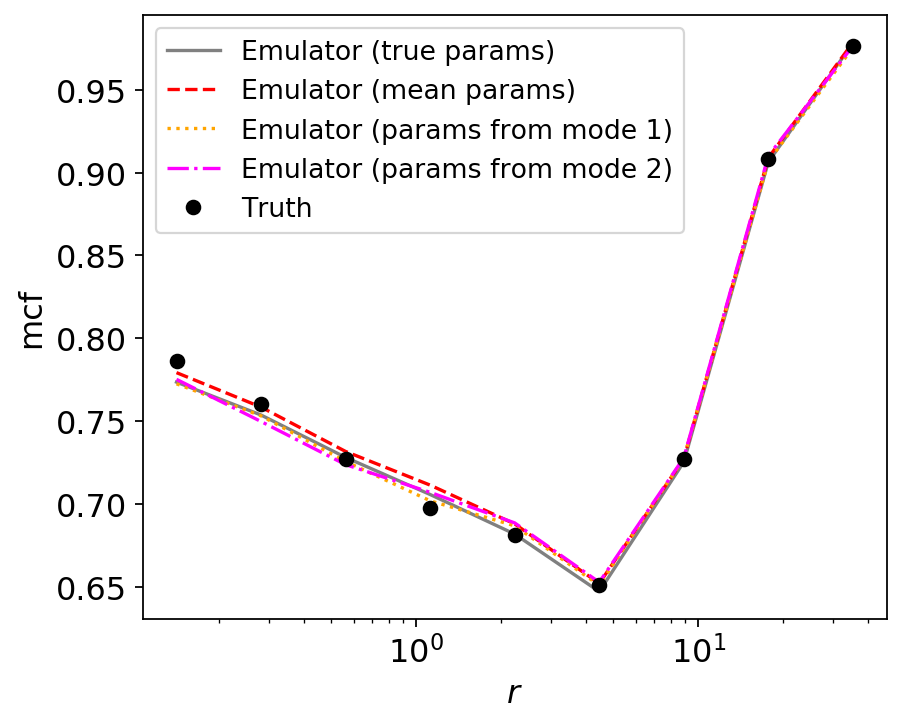

In [221]:
fit_colors = ['grey', 'red', 'orange', 'magenta']
plot_fits(statistics, vals_arr_all, fit_labels, fit_colors, title='')

In [177]:
for i in range(1,20):
    p = get_minlogl_params(res, index=-i)
    
    print(i, p[2], res['logl'][-i])

1 0.8955303938221709 -8.898950471368908
2 0.8889520702594025 -8.954122672103837
3 0.9009673322745485 -9.01115236667269
4 0.9023399772910511 -9.05609996333407
5 0.8988060280466024 -9.115221810777646
6 0.8869916818851915 -9.206786962312798
7 0.8806300889102201 -9.264919839049005
8 0.887003972139393 -9.271797163961146
9 0.8844443876306346 -9.277136088692409
10 0.8726036132801306 -9.293768196038911
11 0.8766669060475358 -9.299323674140767
12 0.880314712360948 -9.304118394372535
13 0.8720524113608055 -9.311917053283343
14 0.8905110222269652 -9.354588620091171
15 0.8866971631796848 -9.400482260563226
16 0.8845532651146599 -9.418344583104904
17 0.8816345462078992 -9.4238151455021
18 0.8985122842833343 -9.427777173398688
19 0.7265169664124574 -9.461108731065657


In [175]:
get_minlogl_params(res, index=-19)

array([ 0.3054571 ,  0.05310405,  0.72651697,  0.66348787,  0.9925833 ,
        3.96408867, -0.82200038, 14.15297107,  1.58551505, 12.36517746,
        0.17499496,  0.71488363,  0.82582151,  1.65323078,  0.70761242,
       -0.06023697,  1.63014088,  0.42973977])

# with fractional errors

In [ ]:
chaintag = 'wp_xi_upf_mcf_c3h3_all_dynesty_dlogz1e-2_nongen_hpriorg'
minlogl_params1 = get_minlogl_params(res, index=-1)
minlogl_params19 = get_minlogl_params(res, index=-19)
mean_params = get_mean_params(res)
true_params = get_true_params(chaintag)
param_arr = [true_params, mean_params, minlogl_params1, minlogl_params19]
statistics, vals_arr_all, vals_true_all = get_fits(chaintag, param_arr)

../../clust/covariances/error_aemulus_wp_hod3_test0.dat
[0.01156016 0.01472741 0.01710767 0.01299131 0.0093331  0.00991669
 0.01256808 0.02101721 0.05011567]
../../clust/covariances/error_aemulus_xi_hod3_test0.dat
[0.05474405 0.03542615 0.02092212 0.0125853  0.00643778 0.00695841
 0.00994987 0.0165276  0.04166294]
../../clust/covariances/error_aemulus_upf_hod3_test0.dat
[0.00026789 0.0014204  0.00452516 0.0076934  0.01624975 0.02818104
 0.04762237 0.10846196 0.19735825]
../../clust/covariances/error_aemulus_mcf_hod3_test0.dat
[0.02911024 0.01192613 0.00859669 0.00600078 0.00375538 0.00336025
 0.00343781 0.0024592  0.00125898]
Building emulators
Rebuilding emulator for wp
[0.02911024 0.01192613 0.00859669 0.00600078 0.00375538 0.00336025
 0.00343781 0.0024592  0.00125898]
Rebuilding emulator for xi
[0.02911024 0.01192613 0.00859669 0.00600078 0.00375538 0.00336025
 0.00343781 0.0024592  0.00125898]
Rebuilding emulator for upf
[0.02911024 0.01192613 0.00859669 0.00600078 0.00375538 0.003

In [ ]:
fit_labels = ['Emulator (true params)', 'Emulator (mean params)', 
              'Emulator (params from mode 1)', 'Emulator (params from mode 2)']
fit_colors = ['grey', 'red', 'orange', 'magenta']
plot_fits(statistics, vals_arr_all, vals_true_all, fit_labels, fit_colors, title=chaintag)